In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import gzip
import numpy as np
import os
import phate
import time
import matplotlib
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import pickle as pk

from collections import defaultdict
import itertools
from scipy.stats import ttest_ind

# Interactive HTML tools
from ipywidgets import interact
import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.palettes import Category20b
from bokeh.palettes import Category20
from bokeh.palettes import Category10
from bokeh.palettes import PRGn
from bokeh.palettes import Set1

# Machine-learning and dimensionality reduction tools
import sklearn
from sklearn import decomposition
from sklearn import linear_model
from sklearn.decomposition import PCA as PCA # We'll use this to check our implementation
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS

import seaborn as sns

# Importing principal components

In [2]:
data_dir = '/Volumes/Stockage/alex/ukbb_projections'

# Define the files we'll be using
pc_file = 'ukbb_pca_only'

#aux_path = os.path.join(hrs_data_dir, aux_file)
pc_path = os.path.join(data_dir, pc_file)

# Import PC data. This data must be converted to an array.
with open(pc_path) as pc:
    pca_contents = pc.readlines()

pca_data = []

for pc in pca_contents[1:]:
    pca_data.append(pc.split()[3:len(pc)])

# Purely numeric values of PCA
pca_data_array = np.array(pca_data).astype(np.float)
#pca_data_array = np.array(pca_data).astype(np.)

In [3]:
pca_data_array.shape

(488377, 40)

# Importing auxiliary data

Field 21000 is ethnicity. Documentation is provided here: http://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=21000

In [4]:
aux_data_dir = '/Users/alex/Documents/Ethnicity'

# Import the auxiliary data and reduce it to the ethnicity information and the IDs
#ukbb_aux_df = pd.read_csv(os.path.join(aux_data_dir,'ukb4940.csv'))
ukbb_aux_df = pd.read_csv('/Users/alex/Documents/Ethnicity/UKBB_pheno/ukb4940.csv')
ukbb_aux_df = ukbb_aux_df.filter(['eid','21000-0.0','21000-1.0'])

# Create a string ID to match PCA (I don't want to touch the PCA dataset as its order is more important)
ukbb_aux_df['eid_str'] = ukbb_aux_df['eid'].apply(str)
ukbb_aux_df.columns=['eid','eth1','eth2','eid_str']
#ukbb_aux_df['eth1'] = ukbb_aux_df['eth1'].apply(int)

# Take care of NA values
ukbb_aux_df['eth1'] = ukbb_aux_df['eth1'].fillna(-9).astype(int)
ukbb_aux_df.loc[(ukbb_aux_df['eth2'].isnull()==True), 'eth2'] = ukbb_aux_df.loc[(ukbb_aux_df['eth2'].isnull()==True), 'eth1']
ukbb_aux_df['eth2'] = ukbb_aux_df['eth2'].fillna(-9).astype(int)

# Convert ethnicities to strings (digits represent categories)
ukbb_aux_df['eth1_str'] = ukbb_aux_df['eth1'].astype(str)
ukbb_aux_df['eth2_str'] = ukbb_aux_df['eth2'].astype(str)

In [5]:
#ukbb_aux_df.groupby('eth1_str').count()
#set(ukbb_aux_df['eth1_str'].values.tolist())

In [6]:
# Import geography data
# The grid coordinate data are provided in the British National Grid (i.e. OSGB1936) projection.
# OSGB1936 is the Ordnance Survey National Grid geographic reference system
# See https://epsg.io/map#srs=27700 for a demo
geo_file = 'eid_df22006_df129north_df130east.mer'

ukbb_geo_df = pd.read_csv(os.path.join(aux_data_dir,geo_file))
ukbb_geo_df.columns=['eid','genetic_grouping','northing','easting']
ukbb_geo_df['northing_orig']=ukbb_geo_df['northing']
ukbb_geo_df['easting_orig']=ukbb_geo_df['easting']


mask = ukbb_geo_df.northing.isnull()
col_name = 'northing'
ukbb_geo_df.loc[mask, col_name] = 0

mask = ukbb_geo_df.easting.isnull()
col_name = 'easting'
ukbb_geo_df.loc[mask, col_name] = 0

mask = ukbb_geo_df.northing < 0
col_name = 'northing'
ukbb_geo_df.loc[mask, col_name] = 0

mask = ukbb_geo_df.easting < 0
col_name = 'easting'
ukbb_geo_df.loc[mask, col_name] = 0

ukbb_geo_df['northing']=ukbb_geo_df['northing']/max(ukbb_geo_df['northing'])
ukbb_geo_df['easting']=ukbb_geo_df['easting']/max(ukbb_geo_df['easting'])
ukbb_geo_df['eid_str_geo'] = ukbb_geo_df['eid'].astype(str)

# Fill NaN values
ukbb_geo_df['northing_filled'] = ukbb_geo_df['northing_orig'].fillna(0)
ukbb_geo_df['easting_filled'] = ukbb_geo_df['easting_orig'].fillna(0)

ukbb_geo_df

,eid,genetic_grouping,northing,easting,northing_orig,easting_orig,eid_str_geo,northing_filled,easting_filled
0,3341191,NaN,0.151014,0.783371,182500.0,513500.0,3341191,182500.0,513500.0
1,4316233,1.0,0.144394,0.790999,174500.0,518500.0,4316233,174500.0,518500.0
2,5682501,NaN,0.000000,0.000000,NaN,NaN,5682501,0.0,0.0
3,2605007,NaN,0.285892,0.696415,345500.0,456500.0,2605007,345500.0,456500.0
4,2537402,NaN,0.138602,0.789474,167500.0,517500.0,2537402,167500.0,517500.0
5,5336616,NaN,0.359537,0.656751,434500.0,430500.0,5336616,434500.0,430500.0
6,1270574,NaN,0.294994,0.687262,356500.0,450500.0,1270574,356500.0,450500.0
7,2503395,1.0,0.266860,0.647597,322500.0,424500.0,2503395,322500.0,424500.0
8,3020054,NaN,0.422424,0.490465,510500.0,321500.0,3020054,510500.0,321500.0
9,2854838,NaN,0.429044,0.684211,518500.0,448500.0,2854838,518500.0,448500.0


In [7]:
ukbb_geo_df.loc[ukbb_geo_df['eid']==-1]

,eid,genetic_grouping,northing,easting,northing_orig,easting_orig,eid_str_geo,northing_filled,easting_filled


In [8]:
northing_orig = ukbb_geo_df['northing_orig'].values
northing_orig = northing_orig[np.isnan(northing_orig)==False]
#plt.hist(northing_orig)

In [9]:
easting_orig = ukbb_geo_df['easting_orig'].values
easting_orig = easting_orig[np.isnan(easting_orig)==False]
#plt.hist(easting_orig)

In [10]:
northing = ukbb_geo_df['northing'].values
northing = northing[northing>0]
#plt.hist(northing)

In [11]:
# Read in the PCA IDs as a pandas data frame
with open(pc_path) as pc:
    pca_contents = pc.readlines()

pca_data_aux = []

for pc in pca_contents[1:]:
    pca_data_aux.append(pc.split()[0:2])

ukbb_pca_df = pd.DataFrame.from_records(pca_data_aux)
ukbb_pca_df.columns = ['FID','IID']

In [12]:
# Join the ethnicities to the PCA IDs
ukbb_df_joined = ukbb_pca_df.merge(ukbb_aux_df, left_on='IID', right_on='eid_str', how='left')

In [13]:
ukbb_df_joined

,FID,IID,eid,eth1,eth2,eid_str,eth1_str,eth2_str
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001


In [14]:
# Join the geographic values
ukbb_df_joined2 = ukbb_df_joined.merge(ukbb_geo_df, left_on='IID', right_on='eid_str_geo', how='left')
ukbb_df_joined2

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,northing,easting,northing_orig,easting_orig,eid_str_geo,northing_filled,easting_filled
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,0.000000,0.000000,NaN,NaN,5806400,0.0,0.0
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,0.224659,0.655225,271500.0,429500.0,2933933,271500.0,429500.0
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,0.324783,0.511823,392500.0,335500.0,3061593,392500.0,335500.0
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,0.184113,0.699466,222500.0,458500.0,5051807,222500.0,458500.0
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,0.155151,0.848970,187500.0,556500.0,4789231,187500.0,556500.0
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,0.141911,0.517925,171500.0,339500.0,1039230,171500.0,339500.0
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,0.099710,0.479786,120500.0,314500.0,3562010,120500.0,314500.0
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,0.137774,0.519451,166500.0,340500.0,5851120,166500.0,340500.0
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,0.318163,0.661327,384500.0,433500.0,4712123,384500.0,433500.0
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,0.351262,0.581998,424500.0,381500.0,4937825,424500.0,381500.0


In [15]:
# Some weird missing values still around
ukbb_df_joined2['easting_filled'] = ukbb_df_joined2['easting_filled'].fillna(0)
ukbb_df_joined2['northing_filled'] = ukbb_df_joined2['northing_filled'].fillna(0)
ukbb_df_joined2['eth1_str'] = ukbb_df_joined2['eth1_str'].fillna('-9')

In [16]:
ukbb_geo_colours = ukbb_df_joined2[['northing','easting']]
# Fix rare NaNs (where there was no data for individuals)
ukbb_geo_colours['northing'] = ukbb_geo_colours['northing'].fillna(0).astype(float)
ukbb_geo_colours['easting'] = ukbb_geo_colours['easting'].fillna(0).astype(float)

ukbb_geo_colours = ukbb_geo_colours.values.tolist()

# Create a list of the original values too
ukbb_geo_colours_orig = ukbb_df_joined2[['northing_filled','easting_filled']].values.tolist()

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
# Put together a dict of values
# Taken from: http://biobank.ctsu.ox.ac.uk/crystal/coding.cgi?id=1001
# Primary dict covers all values
ukbb_eth_dict = {
    '1':'White',
    '1001':'British',
    '1002':'Irish',
    '1003':'Any other white background',
    '2':'Mixed',
    '2001':'White and Black Caribbean',
    '2002':'White and Black African',
    '2003':'White and Asian',
    '2004':'Any other mixed background',
    '3':'Asian or Asian British',
    '3001':'Indian',
    '3002':'Pakistani',
    '3003':'Bangladeshi',
    '3004':'Any other Asian background',
    '4':'Black or Black British',
    '4001':'Caribbean',
    '4002':'African',
    '4003':'Any other Black background',
    '5':'Chinese',
    '6':'Other ethnic group',
    '-1':'Do not know',
    '-3':'Prefer not to answer',
    '-9':'Not available'
}

ukbb_dict_child = {
    '1001':'British',
    '1002':'Irish',
    '1003':'Any other white background',
    '2001':'White and Black Caribbean',
    '2002':'White and Black African',
    '2003':'White and Asian',
    '2004':'Any other mixed background',
    '3001':'Indian',
    '3002':'Pakistani',
    '3003':'Bangladeshi',
    '3004':'Any other Asian background',
    '4001':'Caribbean',
    '4002':'African',
    '4003':'Any other Black background',
    '5':'Chinese',
    '6':'Other ethnic group',
    '-1':'Do not know',
    '-3':'Prefer not to answer',
    '-9':'Not available'    
}

# Parent categories of ethnicities
ukbb_dict_parent = {
    '1':'White',
    '2':'Mixed',
    '3':'Asian or Asian British',
    '4':'Black or Black British',
    '5':'Chinese',
    '6':'Other ethnic group',
    '-':'NA'
}

# Secondary relationship between parent-child ethnicities
ukbb_eth_dict_parent = defaultdict(list)

for key,value in ukbb_eth_dict.items():
    parent = key[0]
    
    if key not in ['1','2','3','4']:
        try:
            ukbb_eth_dict_parent[ukbb_dict_parent[parent]].append(value)
        except KeyError:
            ukbb_eth_dict_parent[ukbb_dict_parent[parent]] = value
            
# Reversed dictionaries
ukbb_dict_child_rev = dict()

for key, value in ukbb_dict_child.items():
    ukbb_dict_child_rev.update({value: key})

#ukbb_eth_dict_parent

In [19]:
ukbb_eth_dict

{'-1': 'Do not know',
 '-3': 'Prefer not to answer',
 '-9': 'Not available',
 '1': 'White',
 '1001': 'British',
 '1002': 'Irish',
 '1003': 'Any other white background',
 '2': 'Mixed',
 '2001': 'White and Black Caribbean',
 '2002': 'White and Black African',
 '2003': 'White and Asian',
 '2004': 'Any other mixed background',
 '3': 'Asian or Asian British',
 '3001': 'Indian',
 '3002': 'Pakistani',
 '3003': 'Bangladeshi',
 '3004': 'Any other Asian background',
 '4': 'Black or Black British',
 '4001': 'Caribbean',
 '4002': 'African',
 '4003': 'Any other Black background',
 '5': 'Chinese',
 '6': 'Other ethnic group'}

In [20]:
# Prepare the indices by category
population_by_individual = defaultdict(int)
individual_by_population = defaultdict(list)
indices_of_population_members = defaultdict(list)

for k in ukbb_eth_dict.keys():
    temp_list = ukbb_df_joined[ukbb_df_joined['eth1_str']==k].index.values.tolist()
    indices_of_population_members[ukbb_eth_dict[k]] = temp_list

In [21]:
# Counts of ethnicities
temp_count = ukbb_df_joined2[['eth1_str','FID']].groupby('eth1_str', as_index=False).count()
temp_eth_df = pd.DataFrame(list(ukbb_eth_dict.items()), columns=['eth_code','eth'])
temp_count_2 = temp_count.merge(temp_eth_df, left_on='eth1_str', right_on='eth_code', how='left')
temp_count_2
#ukbb_df_joined2 = ukbb_df_joined.merge(ukbb_geo_df, left_on='IID', right_on='eid_str_geo', how='left')

,eth1_str,FID,eth_code,eth
0,-1,204,-1,Do not know
1,-3,1583,-3,Prefer not to answer
2,-9,525,-9,Not available
3,1,546,1,White
4,1001,431110,1001,British
5,1002,12760,1002,Irish
6,1003,15822,1003,Any other white background
7,2,46,2,Mixed
8,2001,597,2001,White and Black Caribbean
9,2002,402,2002,White and Black African


In [22]:
#with open('/Volumes/Stockage/alex/other/ukbb_eth1.txt','w') as file:
#    for item in ukbb_df_joined2['eth1_str'].values.tolist():
#        outline = ukbb_eth_dict[item]
#        file.write('%s\n' % outline)

In [23]:
set(ukbb_df_joined2['eth1_str'].values.tolist())

{'-1',
 '-3',
 '-9',
 '1',
 '1001',
 '1002',
 '1003',
 '2',
 '2001',
 '2002',
 '2003',
 '2004',
 '3',
 '3001',
 '3002',
 '3003',
 '3004',
 '4',
 '4001',
 '4002',
 '4003',
 '5',
 '6'}

Code key:

|Coding|Meaning|Node|Parent
|------|-------|----|------
|1|White|1|Top
|1001|British|1001|1
|2001|White and Black Caribbean|2001|2
|3001|Indian|3001|3
|4001|Caribbean|4001|4
|2|Mixed|2|Top
|1002|Irish|1002|1
|2002|White and Black African|2002|2
|3002|Pakistani|3002|3
|4002|African|4002|4
|3|Asian or Asian British|3|Top
|1003|Any other white background|1003|1
|2003|White and Asian|2003|2
|3003|Bangladeshi|3003|3
|4003|Any other Black background|4003|4
|4|Black or Black British|4|Top
|2004|Any other mixed background|2004|2
|3004|Any other Asian background|3004|3
|5|Chinese|5|Top
|6|Other ethnic group|6|Top
|-1|Do not know|-1|Top
|-3|Prefer not to answer|-3|Top

In [24]:
from bokeh.palettes import Plasma256
from bokeh.palettes import Category20c
from bokeh.palettes import Category20
from bokeh.palettes import Category10
from bokeh.palettes import BuGn
from bokeh.palettes import Purples
from bokeh.palettes import YlOrBr
from bokeh.palettes import Blues
from bokeh.palettes import Spectral
from bokeh.palettes import PuBuGn
from bokeh.palettes import RdPu
from bokeh.palettes import Reds

# PARENT - Child colours
# WHITE - British, Irish, Other
# MIXED - W&B Caribbean, W&B African, W&Asian, Other
# ASIAN/ASIAN BRITISH - Indian, Pakistani, Bangladeshi, Other
# CHINESE
# OTHER
# DK, NO ANSWER, N/A

color_list = Category20b[20]+Spectral[11]

counter = 0
# Set up the colours (matplotlib tab20c)
color_dict_ukbb = {}

for pop in ukbb_eth_dict_parent:
    counter=0
    
    # White population is blue (or not, sitll choosing whatevs)
    if pop=='White':
        #color_dict_ukbb[pop]=Category20c[20][counter]
        color_dict_ukbb[pop]=PuBuGn[9][counter]
        #color_dict_ukbb[pop]=color_list[counter]
        counter+=1
        for subpop in ukbb_eth_dict_parent[pop]:
            #color_dict_ukbb[subpop] = Category20c[20][counter]
            color_dict_ukbb[subpop] = PuBuGn[9][counter*2]
            #color_dict_ukbb[subpop]=color_list[counter]
            counter+=1
    # Mixed population is green
    elif pop=='Mixed':
        color_dict_ukbb[pop]=BuGn[9][counter]
        color_dict_ukbb['White and Black Caribbean']=Category10[3][-2] # Orange
        color_dict_ukbb['White and Black African']=Category10[4][-1] # Red
        color_dict_ukbb['White and Asian']=Category10[5][-1] # Purple
        color_dict_ukbb['Any other mixed background']=Category10[3][-1] # Green
    elif pop in ['Asian or Asian British']:
        color_dict_ukbb[pop]=Purples[9][0] # Dark purple
        color_dict_ukbb['Indian']=RdPu[9][0] # Dark red-purple
        color_dict_ukbb['Pakistani']=RdPu[9][2] # More pinkish dark red-purple
        color_dict_ukbb['Bangladeshi']=RdPu[9][4] # Even more pinkish dark red-purple
        color_dict_ukbb['Any other Asian background']=RdPu[9][-3] # Lighter red-purple
    elif pop in ['Chinese']:
        color_dict_ukbb[pop]=Category20[13][-1]
        counter+=1
    # Black population is yellow/orange/brown
    elif pop=='Black or Black British':
        color_dict_ukbb['Black or Black British']=YlOrBr[9][4] # Hazy orange
        color_dict_ukbb['Caribbean']=Reds[9][4] # Hazy red
        color_dict_ukbb['African']=Reds[9][0] # Deep red
        color_dict_ukbb['Any other Black background']=YlOrBr[9][-4] # Lighter Hazy orange
        #color_dict_ukbb[pop]=color_list[counter]
        #counter+=1
        #for subpop in ukbb_eth_dict_parent[pop]:
            #color_dict_ukbb[subpop] = YlOrBr[9][counter]
            #color_dict_ukbb[subpop]=color_list[counter]
            #counter+=1
    # Other ethnic groups are some variety of grey
    elif pop=='Other ethnic group':
        for subpop in ukbb_eth_dict_parent[pop]:
            color_dict_ukbb[subpop] = Category20c[20][16+counter]
            #color_dict_ukbb[subpop]=color_list[counter]
            counter+=1
    elif pop=='NA':
        for subpop in ukbb_eth_dict_parent[pop]:
            color_dict_ukbb[subpop] = Category20c[20][17+counter]
            #color_dict_ukbb[subpop]=color_list[counter]
            counter+=1

In [25]:
ukbb_eth_dict_parent

defaultdict(list,
            {'Asian or Asian British': ['Indian',
              'Pakistani',
              'Bangladeshi',
              'Any other Asian background'],
             'Black or Black British': ['Caribbean',
              'African',
              'Any other Black background'],
             'Chinese': ['Chinese'],
             'Mixed': ['White and Black Caribbean',
              'White and Black African',
              'White and Asian',
              'Any other mixed background'],
             'NA': ['Do not know', 'Prefer not to answer', 'Not available'],
             'Other ethnic group': ['Other ethnic group'],
             'White': ['British', 'Irish', 'Any other white background']})

In [26]:
color_dict_ukbb

{'African': '#67000d',
 'Any other Asian background': '#fcc5c0',
 'Any other Black background': '#fec44f',
 'Any other mixed background': '#2ca02c',
 'Any other white background': '#d0d1e6',
 'Asian or Asian British': '#3f007d',
 'Bangladeshi': '#f768a1',
 'Black or Black British': '#fe9929',
 'British': '#02818a',
 'Caribbean': '#fb6a4a',
 'Chinese': '#e377c2',
 'Do not know': '#969696',
 'Indian': '#49006a',
 'Irish': '#67a9cf',
 'Mixed': '#00441b',
 'Not available': '#d9d9d9',
 'Other ethnic group': '#636363',
 'Pakistani': '#ae017e',
 'Prefer not to answer': '#bdbdbd',
 'White': '#014636',
 'White and Asian': '#9467bd',
 'White and Black African': '#d62728',
 'White and Black Caribbean': '#ff7f0e'}

In [27]:
ukbb_eth_dict

{'-1': 'Do not know',
 '-3': 'Prefer not to answer',
 '-9': 'Not available',
 '1': 'White',
 '1001': 'British',
 '1002': 'Irish',
 '1003': 'Any other white background',
 '2': 'Mixed',
 '2001': 'White and Black Caribbean',
 '2002': 'White and Black African',
 '2003': 'White and Asian',
 '2004': 'Any other mixed background',
 '3': 'Asian or Asian British',
 '3001': 'Indian',
 '3002': 'Pakistani',
 '3003': 'Bangladeshi',
 '3004': 'Any other Asian background',
 '4': 'Black or Black British',
 '4001': 'Caribbean',
 '4002': 'African',
 '4003': 'Any other Black background',
 '5': 'Chinese',
 '6': 'Other ethnic group'}

In [28]:
ukbb_eth_dict_parent

defaultdict(list,
            {'Asian or Asian British': ['Indian',
              'Pakistani',
              'Bangladeshi',
              'Any other Asian background'],
             'Black or Black British': ['Caribbean',
              'African',
              'Any other Black background'],
             'Chinese': ['Chinese'],
             'Mixed': ['White and Black Caribbean',
              'White and Black African',
              'White and Asian',
              'Any other mixed background'],
             'NA': ['Do not know', 'Prefer not to answer', 'Not available'],
             'Other ethnic group': ['Other ethnic group'],
             'White': ['British', 'Irish', 'Any other white background']})

In [29]:
markers_dict = {
    'White':'o',
    'Mixed':'*',
    'Asian or Asian British':'P',
    'Black or Black British':'P',
    'Chinese':'^',
    'Other ethnic group':'s',
    'NA':'X'
}

# Check t-SNE projections

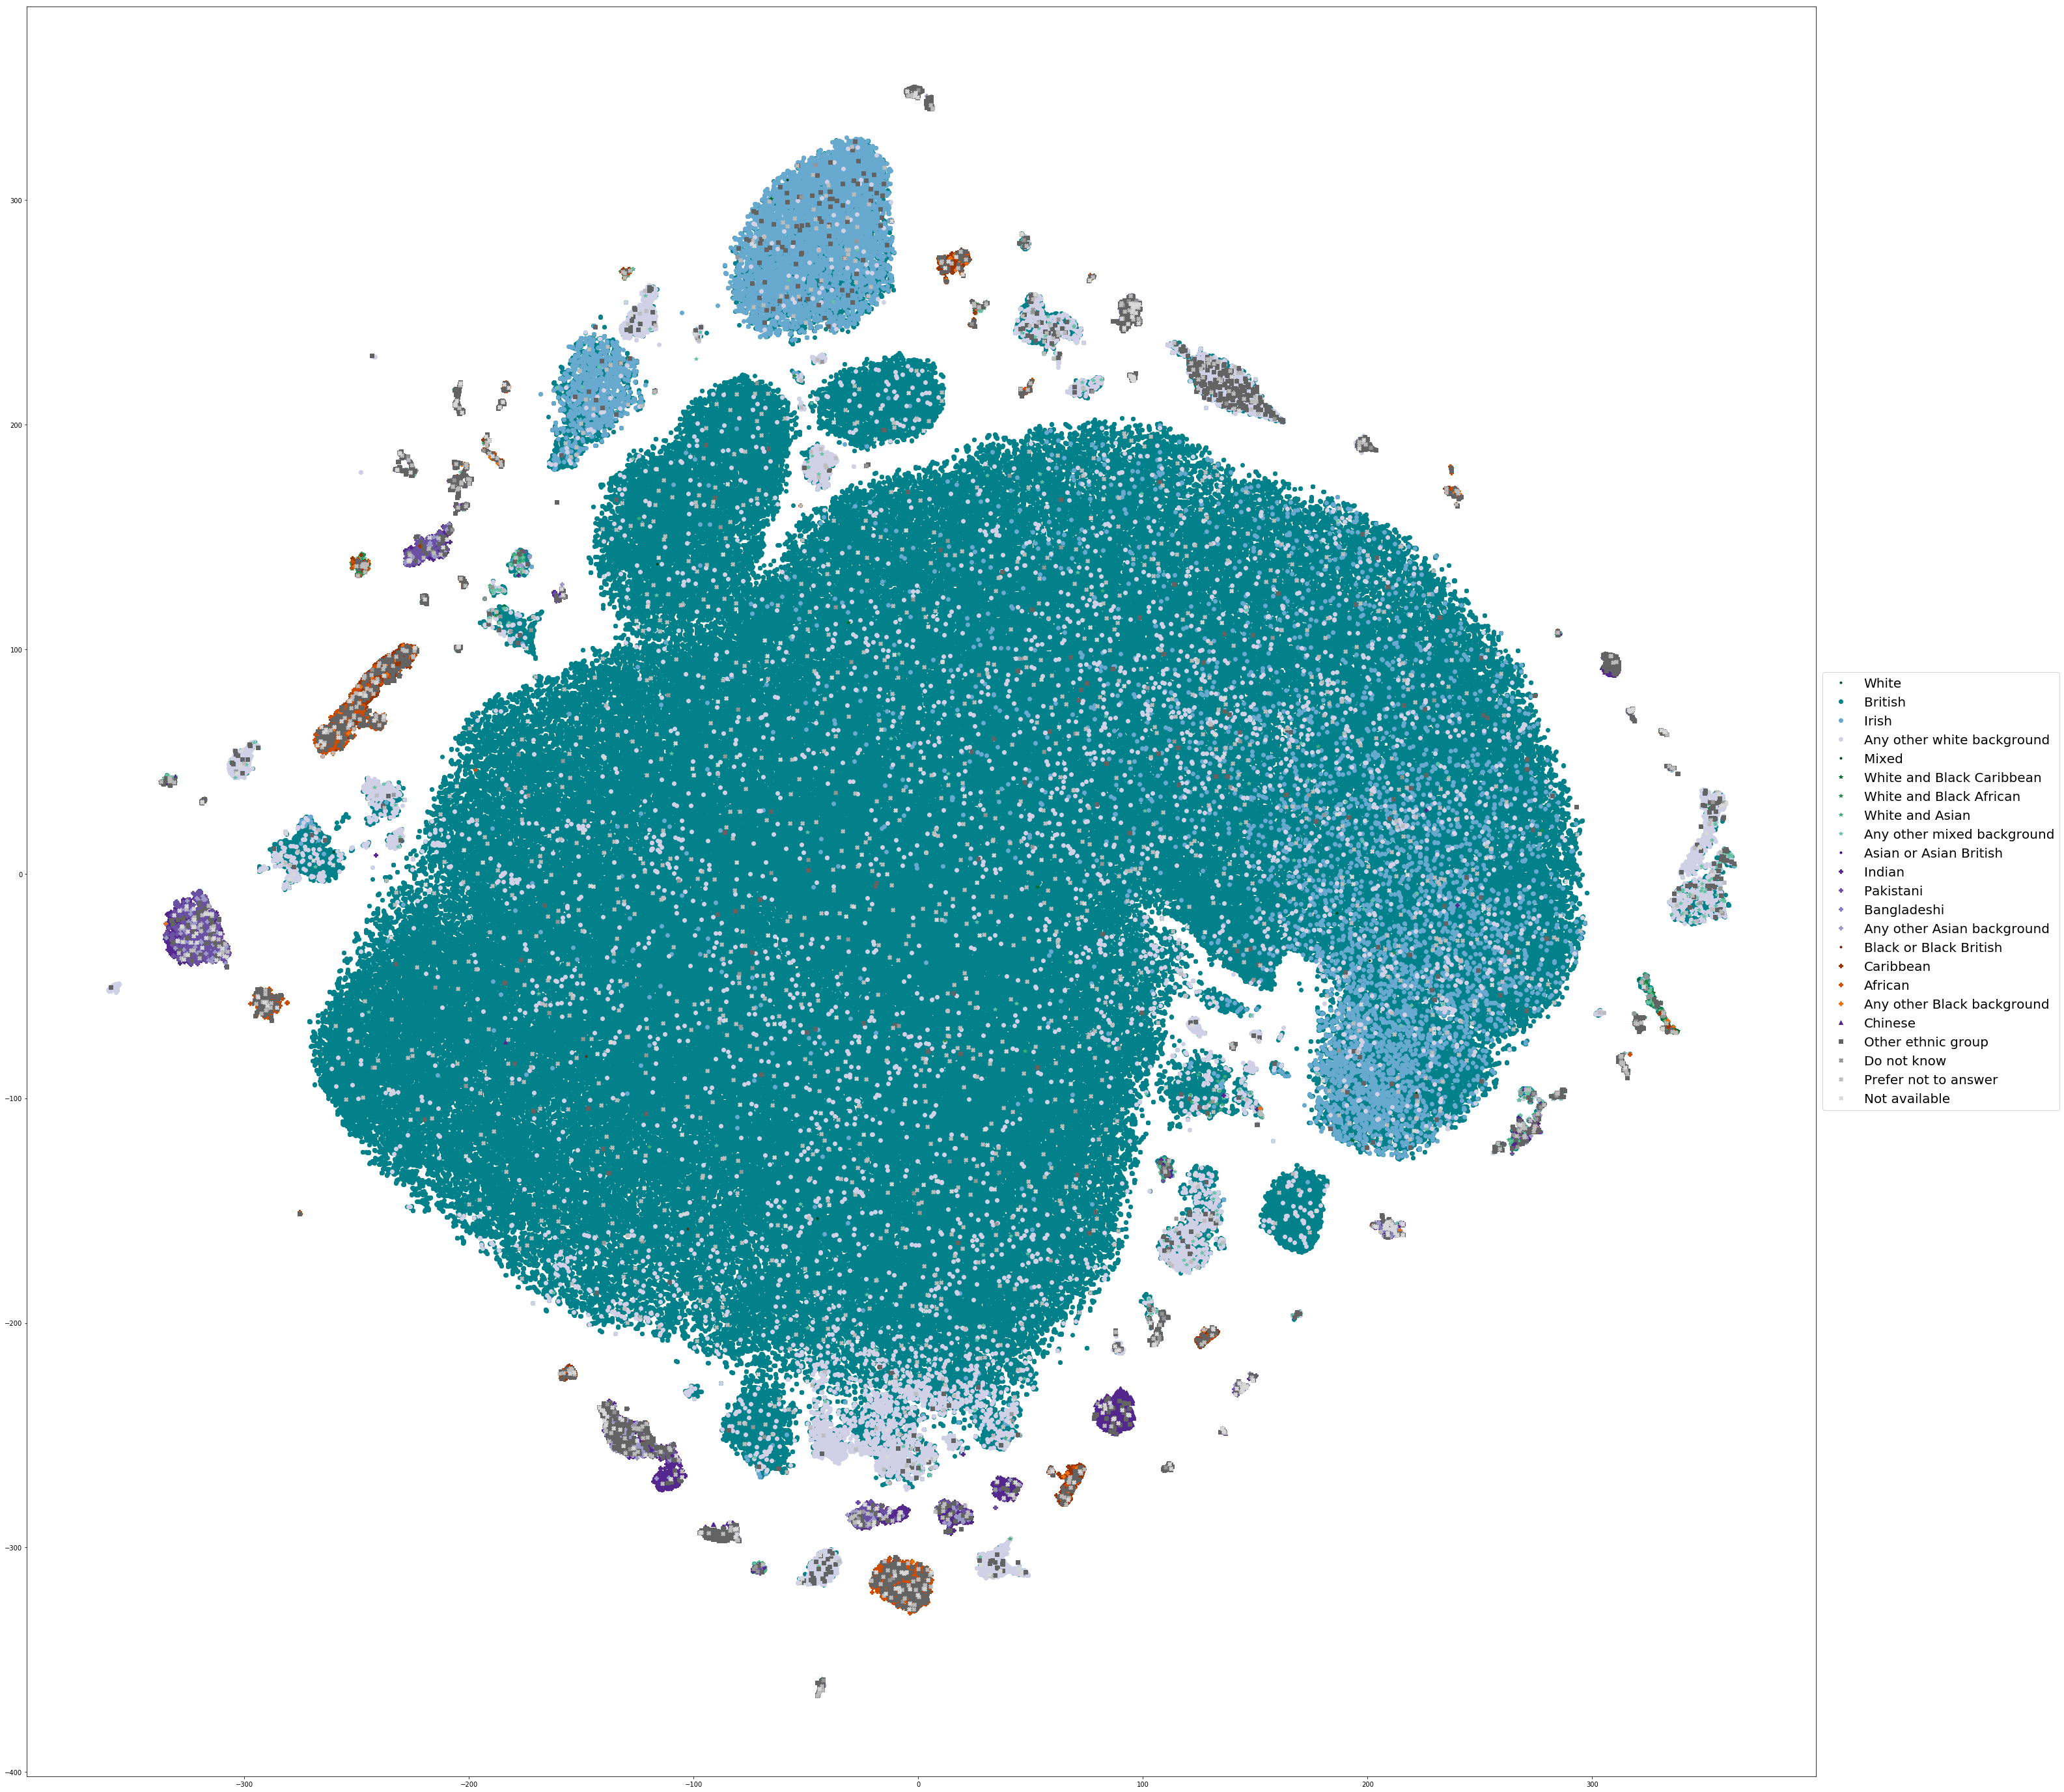

In [313]:
# Load and colour in some tSNE
tsne_proj = np.loadtxt('/Users/alex/Documents/Ethnicity/ukbb_tsne_pc10_plex_iter_20000_tsne_skl')

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

for pop in ukbb_eth_dict_parent:
    if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
        temp_proj = tsne_proj[indices_of_population_members[pop],:]
        ax.plot(temp_proj[:,0], temp_proj[:,1],'.',label=pop,color=color_dict_ukbb[pop])

    for subpop in ukbb_eth_dict_parent[pop]:
        temp_proj = tsne_proj[indices_of_population_members[subpop],:]
        ax.plot(temp_proj[:,0], temp_proj[:,1],markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop])

ax.legend(ncol=1,loc='center left', bbox_to_anchor=(1,0.5), fontsize=20)

# Geographical colouring

In [30]:
temp1 = [t[0] for t in ukbb_geo_colours_orig if t[0] > 0]
temp2 = [t[1] for t in ukbb_geo_colours_orig if t[1] > 0]

In [31]:
easting_mean = np.mean(easting_orig)
northing_mean = np.mean(northing_orig)

In [32]:
easting_mean, northing_mean

(403551.27795793407, 352173.30010942009)

In [32]:
# We'd like two colour maps: Northing (index 0) and Easting (index 1)
# Create a list of colour values and map them using the warm-to-cold colour map
# Looking at histograms, most individuals are below the 0.8 mark for north and above 0.2 for east
## so we normalize with respect to those (otherwise the colour scale is really uninformative)

# Those with zero values are invalid, so we make them invisible (alpha value of zero)
temp_colours_ns = []
temp_colours_ew = []
temp_alpha = []

ns_min = 100000
ns_max = 700000
ew_min = 200000
ew_max = 600000
alpha_vals = 0.6

# Deal with specific cases
for u in ukbb_geo_colours_orig:
    no_geo = False
    # Set alpha to zero for unknown geo values
    if u[0]<=0 or u[1]<=0:
        no_geo = True
        temp_alpha.append(np.float(0))
        temp_colours_ns.append(northing_mean)
        temp_colours_ew.append(easting_mean)

    if no_geo==False:
        if u[0] < ns_min:
            temp_colours_ns.append(ns_min)
        elif u[0] > ns_max:
            temp_colours_ns.append(ns_max)
        else:
            temp_colours_ns.append(u[0])
        
        if u[1] < ew_min:
            temp_colours_ew.append(ew_min)
        elif u[1] > ew_max:
            temp_colours_ew.append(ew_max)
        else:
            temp_colours_ew.append(u[1])
                        
        temp_alpha.append(np.float(alpha_vals))

norm_ns = matplotlib.colors.Normalize(vmin=ns_min, vmax=ns_max, clip=False)
norm_ew = matplotlib.colors.Normalize(vmin=ew_min, vmax=ew_max, clip=False)
mapper_ns = cm.ScalarMappable(norm=norm_ns, cmap=cm.coolwarm_r)
#mapper_ew = cm.ScalarMappable(norm=norm_ew, cmap=cm.YlGn_r)
mapper_ew = cm.ScalarMappable(norm=norm_ew, cmap=cm.spring)

In [33]:
colours_ns = []
colours_ew = []
    
for i in range(0, len(temp_colours_ns)):
    colours_ns.append(mapper_ns.to_rgba(temp_colours_ns[i], alpha=temp_alpha[i]))
    colours_ew.append(mapper_ew.to_rgba(temp_colours_ew[i], alpha=temp_alpha[i]))

In [34]:
# Not totally sure why I have to do this but I have wasted too much time on this stupid color bar
mapper_ns_temp = mapper_ns
mapper_ew_temp = mapper_ew

mapper_ns_temp._A = []
mapper_ew_temp._A = []

In [ ]:
# Carry out geographical colouring for various projections
proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
img_dir = '/Volumes/Stockage/alex/ukbb_images/geo'

for file in os.listdir(proj_dir):
    if os.path.isdir(os.path.join(proj_dir, file)) or file=='ukbb_pca_only':
        continue
    
    tsne_proj = np.loadtxt(os.path.join(proj_dir,file))
    
    # North-South colouring
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111, aspect=1)

    ax.scatter(tsne_proj[:,0], tsne_proj[:,1], c=colours_ns, cmap=cm.coolwarm_r, s=5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom',size='5%',pad=0.05)

    cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
    cbar.set_label('SOUTH<---->NORTH')

    fig.savefig(os.path.join(img_dir,file + '_ns.jpeg'),format='jpeg')
    plt.close()
    
    # East-West colouring
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111, aspect=1)

    ax.scatter(tsne_proj[:,0], tsne_proj[:,1], c=colours_ew, cmap=cm.spring, s=5)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom',size='5%',pad=0.05)

    cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
    cbar.set_label('WEST<---->EAST')

    fig.savefig(os.path.join(img_dir,file + '_ew.jpeg'),format='jpeg')
    plt.close()
    
    # Ethnicity colouring
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111, aspect=1)

    for pop in ukbb_eth_dict_parent:
        if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
            temp_proj = tsne_proj[indices_of_population_members[pop],:]
            ax.plot(temp_proj[:,0], temp_proj[:,1],'.',label=pop,color=color_dict_ukbb[pop],alpha=0.6)

        for subpop in ukbb_eth_dict_parent[pop]:
            temp_proj = tsne_proj[indices_of_population_members[subpop],:]
            ax.plot(temp_proj[:,0], temp_proj[:,1],markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop],alpha=0.6)

    ax.legend(ncol=4,loc='lower center', bbox_to_anchor=(0.4,-0.12), fontsize=40,markerscale=10)

    fig.savefig(os.path.join(img_dir,file + '_eth.jpeg'),format='jpeg')
    plt.close()

In [71]:
# testing ground
proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
img_dir = '/Volumes/Stockage/alex/ukbb_images/height/test'
file = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'

tsne_proj = np.loadtxt(os.path.join(proj_dir,file))
    
# North-South colouring
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(tsne_proj[:,0], tsne_proj[:,1], c=colours_ns, cmap=cm.coolwarm_r, s=5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
cbar.set_label('SOUTH<---->NORTH')

fig.savefig(os.path.join(img_dir,file + '_ns.jpeg'),format='jpeg')
plt.close()

# East-West colouring
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(tsne_proj[:,0], tsne_proj[:,1], c=colours_ew, cmap=cm.spring, s=5)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
cbar.set_label('WEST<---->EAST')

fig.savefig(os.path.join(img_dir,file + '_ew.jpeg'),format='jpeg')
plt.close()

# Ethnicity colouring
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

for pop in ukbb_eth_dict_parent:
    if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
        temp_proj = tsne_proj[indices_of_population_members[pop],:]
        ax.plot(temp_proj[:,0], temp_proj[:,1],'.',label=pop,color=color_dict_ukbb[pop],alpha=0.6)

    for subpop in ukbb_eth_dict_parent[pop]:
        temp_proj = tsne_proj[indices_of_population_members[subpop],:]
        ax.plot(temp_proj[:,0], temp_proj[:,1],markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop],alpha=0.6)

ax.legend(ncol=4,loc='lower center', bbox_to_anchor=(0.4,-0.12), fontsize=40,markerscale=10)

fig.savefig(os.path.join(img_dir,file + '_eth.jpeg'),format='jpeg')
plt.close()

# Geography experimenting
Look at subsets (e.g. Scotland)

* Glasgow: (260E, 660N)
* Edinburgh: (326E, 670N)

In [60]:
outfile = '/Volumes/Stockage/alex/sandbox/ukbb_geo.txt'

with open(outfile, 'w') as file:
    file.writelines('\t'.join(str(j) for j in i) + '\n' for i in ukbb_geo_colours_orig)

In [50]:
# Get indices of geographic coordinates in Scotland
# Scotland is (roughly) everything above the intersection of the lines that pass through: (Easting, Northing)
# L1: (240,720), (250,510)
# L2: (400,650)

scot_temp_alpha = []
scot_temp_colours_ns = []
scot_temp_colours_ew = []

temp_list_ns = [] # temporary list to get an idea of value distribution
temp_list_ew = []

alpha_vals = 0.6

ns_min=510000
ns_max=900000
ew_min=240000
ew_max=350000

# Math note: a point (x0, y0) falls above a line y=a*x + b iff y0 > a*x0 + b
# We have two lines, so we calculate their slops and intercepts
p1 = (240000, 720000)
p2 = (250000, 510000)
p3 = (400000, 650000)

# Calculate slopes as rise over run ie p1[1]-p2[1]
a1 = (p1[1]-p2[1])/(p1[0]-p2[0])
a2 = (p3[1]-p2[1])/(p3[0]-p2[0])

# Calculate intercepts (b = y-a*x)
b1 = p2[1] - a1*p2[0]
b2 = p2[1] - a2*p2[0]

#u[0] is NS (y coord) and u[1] is EW (x coord)

for u in ukbb_geo_colours_orig:
    no_geo = False
    # No geographic data - just make the point invisible
    if u[0]<=0 or u[1]<=0:
        no_geo = True
        scot_temp_alpha.append(np.float(0))
        scot_temp_colours_ns.append(northing_mean)
        scot_temp_colours_ew.append(easting_mean)
    
    if no_geo==False:
        # If the point falls above both of these lines, it's in Scotland
        if u[0] >= a1*u[1] + b1 and u[0] >= a2*u[1] + b2:
            scot_temp_alpha.append(alpha_vals)
            temp_list_ns.append(u[0])
            temp_list_ew.append(u[1])
        else:
            scot_temp_alpha.append(np.float(0))
        
        if u[0] < ns_min:
            scot_temp_colours_ns.append(ns_min)
        elif u[0] > ns_max:
            scot_temp_colours_ns.append(ns_max)
        else:
            scot_temp_colours_ns.append(u[0])
        
        if u[1] < ew_min:
            scot_temp_colours_ew.append(ew_min)
        elif u[1] > ew_max:
            scot_temp_colours_ew.append(ew_max)
        else:
            scot_temp_colours_ew.append(u[1])

    norm_ns = matplotlib.colors.Normalize(vmin=ns_min, vmax=ns_max, clip=False)
    norm_ew = matplotlib.colors.Normalize(vmin=ew_min, vmax=ew_max, clip=False)
    mapper_ns = cm.ScalarMappable(norm=norm_ns, cmap=cm.coolwarm_r)
    mapper_ew = cm.ScalarMappable(norm=norm_ew, cmap=cm.spring)

In [51]:
scot_colours_ns = []
scot_colours_ew = []
    
for i in range(0, len(scot_temp_colours_ns)):
    scot_colours_ns.append(mapper_ns.to_rgba(scot_temp_colours_ns[i], alpha=scot_temp_alpha[i]))
    scot_colours_ew.append(mapper_ew.to_rgba(scot_temp_colours_ew[i], alpha=scot_temp_alpha[i]))

mapper_ns_temp = mapper_ns
mapper_ew_temp = mapper_ew

mapper_ns_temp._A = []
mapper_ew_temp._A = []

In [54]:
proj = np.loadtxt('/Volumes/Stockage/alex/ukbb_projections/UKBB_UMAP_PC20_NC2_NN15_MD0.5_2018454111')

x_coords=proj[:,0]
y_coords=proj[:,1]
point_size=3

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(x_coords, y_coords, c=scot_colours_ns, cmap=cm.coolwarm_r, s=point_size)
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
cbar.set_label('SOUTH<---->NORTH')

fig.savefig('test_ns_2.jpeg',format='jpeg')
plt.close()

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(x_coords, y_coords, c=scot_colours_ew, cmap=cm.spring, s=point_size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
cbar.set_label('WEST<---->EAST')

fig.savefig('test_ew_2.jpeg',format='jpeg')
plt.close()

In [56]:
# Generate one of these for each projection
out_dir = '/Volumes/Stockage/alex/ukbb_images/scotland'
proj_dir = '/Volumes/Stockage/alex/ukbb_projections'

for fname in os.listdir(proj_dir):
    if '3d' in fname or 'NC3' in fname or os.path.isdir(os.path.join(proj_dir,fname)) or fname=='ukbb_pca_only' \
    or os.path.exists(os.path.join(out_dir, fname + '_height_f.jpeg')):
        continue
    else:
        proj = np.loadtxt(os.path.join(proj_dir, fname))

        x_coords=proj[:,0]
        y_coords=proj[:,1]
        point_size=3

        fig = plt.figure(figsize=(50,50))
        ax = fig.add_subplot(111, aspect=1)

        ax.scatter(x_coords, y_coords, c=scot_colours_ns, cmap=cm.coolwarm_r, s=point_size)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom',size='5%',pad=0.05)

        cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
        cbar.set_label('SOUTH<---->NORTH')

        fig.savefig(os.path.join(out_dir, fname + '_scot_ns.jpeg'),format='jpeg')
        plt.close()

        fig = plt.figure(figsize=(50,50))
        ax = fig.add_subplot(111, aspect=1)

        ax.scatter(x_coords, y_coords, c=scot_colours_ew, cmap=cm.spring, s=point_size)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom',size='5%',pad=0.05)

        cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
        cbar.set_label('WEST<---->EAST')

        fig.savefig(os.path.join(out_dir, fname + '_scot_ew.jpeg'),format='jpeg')
        plt.close()

(array([ 12777.,   6660.,   1778.,  10048.,   2446.,    988.,   1129.,
           255.,     16.,     28.]),
 array([ 237500.,  260300.,  283100.,  305900.,  328700.,  351500.,
         374300.,  397100.,  419900.,  442700.,  465500.]),
 <a list of 10 Patch objects>)

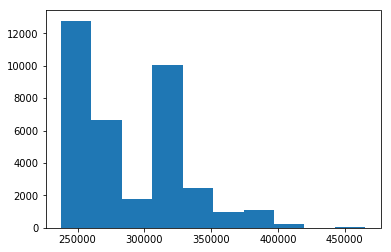

In [42]:
plt.hist(temp_list_ew)

(array([  4.89000000e+02,   2.94520000e+04,   3.44100000e+03,
          1.26100000e+03,   1.23500000e+03,   6.30000000e+01,
          7.80000000e+01,   6.20000000e+01,   2.70000000e+01,
          1.70000000e+01]),
 array([  546500.,   612700.,   678900.,   745100.,   811300.,   877500.,
          943700.,  1009900.,  1076100.,  1142300.,  1208500.]),
 <a list of 10 Patch objects>)

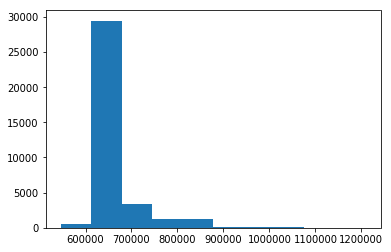

In [41]:
plt.hist(temp_list_ns)

In [93]:
# Look at Scotland only
# Try one with non-Scottish alpha set to 0
temp_colours_ns = []
temp_colours_ew = []
temp_alpha = []

ns_min = 500000
ns_max = 900000
ew_min = 200000
ew_max = 600000
alpha_vals = 0.6

# Deal with specific cases
#u0 = NS, u1=EW
for u in ukbb_geo_colours_orig:
    no_geo = False
    # Set alpha to zero for unknown geo values
    # Also set alpha to zero for 
    if u[0]<=0 or u[1]<=0 or :
        no_geo = True
        temp_alpha.append(np.float(0))
        temp_colours_ns.append(northing_mean)
        temp_colours_ew.append(easting_mean)

    if no_geo==False:
        if u[0] < ns_min:
            temp_colours_ns.append(ns_min)
        elif u[0] > ns_max:
            temp_colours_ns.append(ns_max)
        else:
            temp_colours_ns.append(u[0])
        
        if u[1] < ew_min:
            temp_colours_ew.append(ew_min)
        elif u[1] > ew_max:
            temp_colours_ew.append(ew_max)
        else:
            temp_colours_ew.append(u[1])
        
        # Exclude London
        #if 160000 <= u[0] <= 200000 and 505000 <= u[1] <= 550000:
        # Only Scotland
        if u[0] < 550000 or (u[0] < 600000 and u[1] < 175000):
            temp_alpha.append(0)
        else:
            temp_alpha.append(np.float(alpha_vals))

norm_ns = matplotlib.colors.Normalize(vmin=ns_min, vmax=ns_max, clip=False)
norm_ew = matplotlib.colors.Normalize(vmin=ew_min, vmax=ew_max, clip=False)
mapper_ns = cm.ScalarMappable(norm=norm_ns, cmap=cm.coolwarm_r)
mapper_ew = cm.ScalarMappable(norm=norm_ew, cmap=cm.spring)

SyntaxError: invalid syntax (<ipython-input-93-051986a21fc5>, line 19)

In [94]:
# Try one with non-Scottish alpha set to 0
temp_colours_ns = []
temp_colours_ew = []
temp_alpha = []

ns_min = 500000
ns_max = 900000
ew_min = 200000
ew_max = 600000
alpha_vals = 0.6

# Deal with specific cases
#u0 = NS, u1=EW
for u in ukbb_geo_colours_orig:
    no_geo = False
    # Set alpha to zero for unknown geo values
    if u[0]<=0 or u[1]<=0:
        no_geo = True
        temp_alpha.append(np.float(0))
        temp_colours_ns.append(northing_mean)
        temp_colours_ew.append(easting_mean)

    if no_geo==False:
        if u[0] < ns_min:
            temp_colours_ns.append(ns_min)
        elif u[0] > ns_max:
            temp_colours_ns.append(ns_max)
        else:
            temp_colours_ns.append(u[0])
        
        if u[1] < ew_min:
            temp_colours_ew.append(ew_min)
        elif u[1] > ew_max:
            temp_colours_ew.append(ew_max)
        else:
            temp_colours_ew.append(u[1])
        
        # Exclude London
        #if 160000 <= u[0] <= 200000 and 505000 <= u[1] <= 550000:
        # Only Scotland
        if u[0] < 550000 or (u[0] < 600000 and u[1] < 175000):
            temp_alpha.append(0)
        else:
            temp_alpha.append(np.float(alpha_vals))

norm_ns = matplotlib.colors.Normalize(vmin=ns_min, vmax=ns_max, clip=False)
norm_ew = matplotlib.colors.Normalize(vmin=ew_min, vmax=ew_max, clip=False)
mapper_ns = cm.ScalarMappable(norm=norm_ns, cmap=cm.coolwarm_r)
mapper_ew = cm.ScalarMappable(norm=norm_ew, cmap=cm.spring)

NameError: name 'northing_mean' is not defined

In [72]:
colours_ns = []
colours_ew = []
    
for i in range(0, len(temp_colours_ns)):
    colours_ns.append(mapper_ns.to_rgba(temp_colours_ns[i], alpha=temp_alpha[i]))
    colours_ew.append(mapper_ew.to_rgba(temp_colours_ew[i], alpha=temp_alpha[i]))

mapper_ns_temp = mapper_ns
mapper_ew_temp = mapper_ew

mapper_ns_temp._A = []
mapper_ew_temp._A = []

In [73]:
proj = np.loadtxt('/Volumes/Stockage/alex/ukbb_projections/UKBB_UMAP_PC20_NC2_NN15_MD0.5_2018454111')

x_coords=proj[:,0]
y_coords=proj[:,1]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(x_coords, y_coords, c=colours_ns, cmap=cm.coolwarm_r, s=5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
cbar.set_label('SOUTH<---->NORTH')

fig.savefig('test_ns.jpeg',format='jpeg')
plt.close()

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(x_coords, y_coords, c=colours_ew, cmap=cm.spring, s=5)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
cbar.set_label('WEST<---->EAST')

fig.savefig('test_ew.jpeg',format='jpeg')
plt.close()

# Height analysis

Ok, steps for proper analysis:
1. Split by sex
2. Drop missing
3. Regress and get residuals
4. Merge by IID
5. Plot each sex

In [36]:
# Step 0: Import datasets and merge them (horrible mess of code)

pheno_dir = '/Users/alex/Documents/Ethnicity/UKBB_pheno'
height_file = 'Height.pheno'
covar_file = 'ukb4940.csv'

# File of covariates
ukbb_covar = pd.read_csv(os.path.join(pheno_dir, covar_file))[['eid','31-0.0']]
ukbb_covar.columns = ['eid_covar', 'sex'] # (0 = F, 1 = M)
ukbb_covar['eid_covar']=ukbb_covar['eid_covar'].astype(str)
ukbb_covar['sex']=ukbb_covar['sex'].astype(str)

# Read in the UKBB height phenotype data. We need to join this to the main UKBB dataset to get indexing right.
ukbb_pheno_height = pd.read_csv(os.path.join(pheno_dir,height_file), sep=' ')
ukbb_pheno_height['FID']=ukbb_pheno_height['FID'].astype(str)
ukbb_pheno_height['IID']=ukbb_pheno_height['IID'].astype(str)

ukbb_pheno_height.columns=['FID_height','IID_height','Height']

ukbb_pheno_joined = ukbb_df_joined2.merge(ukbb_pheno_height, left_on='IID', right_on='IID_height', how='left')
ukbb_pheno_joined = ukbb_pheno_joined.merge(ukbb_covar, left_on='IID',right_on='eid_covar', how='left')

ukbb_pheno_age = pd.read_csv('/Users/alex/Documents/Ethnicity/UKBB_pheno/ukb4940.csv')[['eid','21003-0.0']]
ukbb_pheno_age.columns=['EID_age','age']
ukbb_pheno_age['EID_age']=ukbb_pheno_age['EID_age'].astype(str)
ukbb_pheno_age['age'] = ukbb_pheno_age['age'].fillna(0)

ukbb_pheno_joined = ukbb_pheno_joined.merge(ukbb_pheno_age, left_on='FID',right_on='EID_age', how='left')

In [37]:
# Step 1: Split by sex(0=F)
sex_list = ukbb_pheno_joined['sex'].values.tolist()
indices_of_population_sex = defaultdict(list)

for sex in ['0','1']:
    temp_list = ukbb_pheno_joined[ukbb_pheno_joined['sex']==sex].index.values.tolist()
    indices_of_population_sex[sex] = temp_list

ukbb_pheno_joined_f = ukbb_pheno_joined.iloc[indices_of_population_sex['0']]
ukbb_pheno_joined_m = ukbb_pheno_joined.iloc[indices_of_population_sex['1']]

In [38]:
len(indices_of_population_sex['0']) # about 600-700 are missing from the female list

264771

In [39]:
# Step 2: Drop missing values (work with female heights for now)
ukbb_pheno_joined_f=ukbb_pheno_joined_f[ukbb_pheno_joined_f.Height>0]

In [40]:
# Step 3: Regression
X = ukbb_pheno_joined_f[["age"]]
y = ukbb_pheno_joined_f[["Height"]]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

residuals_f = y - lm.predict(X)

In [41]:
lm.intercept_, lm.coef_ # slope of coef should be negative (older => lower height)

(array([ 170.70512405]), array([[-0.1463305]]))

In [42]:
ukbb_pheno_joined_f['Height_res'] = residuals_f
ukbb_pheno_joined_f['Age_coeff'] = lm.coef_[0][0]
ukbb_pheno_joined_f['int'] = lm.intercept_[0]

In [43]:
ukbb_pheno_joined_f

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,FID_height,IID_height,Height,eid_covar,sex,EID_age,age,Height_res,Age_coeff,int
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,2933933,2933933,166.0,2933933,0,2933933,46.0,2.026079,-0.14633,170.705124
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,3061593,3061593,158.0,3061593,0,3061593,52.0,-5.095938,-0.14633,170.705124
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,5051807,5051807,158.0,5051807,0,5051807,65.0,-3.193642,-0.14633,170.705124
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,4789231,4789231,165.5,4789231,0,4789231,56.0,2.989384,-0.14633,170.705124
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,3562010,3562010,162.5,3562010,0,3562010,41.0,-2.205574,-0.14633,170.705124
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,5851120,5851120,166.0,5851120,0,5851120,51.0,2.757731,-0.14633,170.705124
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,4937825,4937825,156.5,4937825,0,4937825,50.0,-6.888599,-0.14633,170.705124
10,2344456,2344456,2344456.0,1001.0,1001.0,2344456,1001,1001,2344456.0,1.0,...,2344456,2344456,172.0,2344456,0,2344456,55.0,9.343053,-0.14633,170.705124
11,1288641,1288641,1288641.0,1001.0,1001.0,1288641,1001,1001,1288641.0,1.0,...,1288641,1288641,164.0,1288641,0,1288641,58.0,1.782045,-0.14633,170.705124
12,4818913,4818913,4818913.0,1001.0,1001.0,4818913,1001,1001,4818913.0,1.0,...,4818913,4818913,164.2,4818913,0,4818913,55.0,1.543053,-0.14633,170.705124


In [44]:
# Do steps 2 and 3 for males
ukbb_pheno_joined_m=ukbb_pheno_joined_m[ukbb_pheno_joined_m.Height>0]

In [45]:
# Step 3: Regression
X = ukbb_pheno_joined_m[["age"]]
y = ukbb_pheno_joined_m[["Height"]]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

residuals_m = y - lm.predict(X)

In [46]:
lm.intercept_, lm.coef_ # slope of coef should be negative (older => lower height)

(array([ 183.44852957]), array([[-0.13784785]]))

In [47]:
ukbb_pheno_joined_m['Height_res'] = residuals_m
ukbb_pheno_joined_m['Age_coeff'] = lm.coef_[0][0]
ukbb_pheno_joined_m['int'] = lm.intercept_[0]

In [48]:
ukbb_pheno_joined_m

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,FID_height,IID_height,Height,eid_covar,sex,EID_age,age,Height_res,Age_coeff,int
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,5806400,5806400,177.0,5806400,1,5806400,41.0,-0.796768,-0.137848,183.44853
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,1039230,1039230,186.0,1039230,1,1039230,50.0,9.443863,-0.137848,183.44853
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,4712123,4712123,167.0,4712123,1,4712123,53.0,-9.142594,-0.137848,183.44853
13,5875536,5875536,5875536.0,1001.0,1001.0,5875536,1001,1001,5875536.0,NaN,...,5875536,5875536,193.5,5875536,1,5875536,47.0,16.530319,-0.137848,183.44853
15,2491506,2491506,2491506.0,1001.0,1001.0,2491506,1001,1001,2491506.0,1.0,...,2491506,2491506,180.0,2491506,1,2491506,48.0,3.168167,-0.137848,183.44853
17,3101820,3101820,3101820.0,1001.0,1001.0,3101820,1001,1001,3101820.0,1.0,...,3101820,3101820,178.0,3101820,1,3101820,63.0,3.235885,-0.137848,183.44853
19,2405323,2405323,2405323.0,1001.0,1001.0,2405323,1001,1001,2405323.0,1.0,...,2405323,2405323,173.4,2405323,1,2405323,53.0,-2.742594,-0.137848,183.44853
20,5301125,5301125,5301125.0,1001.0,1001.0,5301125,1001,1001,5301125.0,1.0,...,5301125,5301125,177.0,5301125,1,5301125,54.0,0.995254,-0.137848,183.44853
21,1916564,1916564,1916564.0,1001.0,1001.0,1916564,1001,1001,1916564.0,1.0,...,1916564,1916564,168.0,1916564,1,1916564,54.0,-8.004746,-0.137848,183.44853
22,4143365,4143365,4143365.0,1001.0,1001.0,4143365,1001,1001,4143365.0,1.0,...,4143365,4143365,155.0,4143365,1,4143365,60.0,-20.177659,-0.137848,183.44853


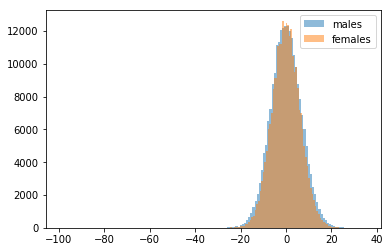

In [49]:
temp_list_m = ukbb_pheno_joined_m['Height_res'].values.tolist()
temp_list_f = ukbb_pheno_joined_f['Height_res'].values.tolist()

plt.hist(temp_list_m, bins=140, alpha=0.5, label='males')
plt.hist(temp_list_f, bins=135, alpha=0.5, label='females')
plt.legend(loc='upper right')
plt.show()

In [50]:
# Step 4a: Combine the two datasets from above
ukbb_pheno_height_res = pd.concat([ukbb_pheno_joined_f, ukbb_pheno_joined_m])

In [51]:
ukbb_pheno_height_res.sort_index()

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,FID_height,IID_height,Height,eid_covar,sex,EID_age,age,Height_res,Age_coeff,int
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,5806400,5806400,177.0,5806400,1,5806400,41.0,-0.796768,-0.137848,183.448530
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,2933933,2933933,166.0,2933933,0,2933933,46.0,2.026079,-0.146330,170.705124
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,3061593,3061593,158.0,3061593,0,3061593,52.0,-5.095938,-0.146330,170.705124
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,5051807,5051807,158.0,5051807,0,5051807,65.0,-3.193642,-0.146330,170.705124
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,4789231,4789231,165.5,4789231,0,4789231,56.0,2.989384,-0.146330,170.705124
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,1039230,1039230,186.0,1039230,1,1039230,50.0,9.443863,-0.137848,183.448530
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,3562010,3562010,162.5,3562010,0,3562010,41.0,-2.205574,-0.146330,170.705124
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,5851120,5851120,166.0,5851120,0,5851120,51.0,2.757731,-0.146330,170.705124
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,4712123,4712123,167.0,4712123,1,4712123,53.0,-9.142594,-0.137848,183.448530
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,4937825,4937825,156.5,4937825,0,4937825,50.0,-6.888599,-0.146330,170.705124


In [52]:
# Step 4b: Get the IID-residual height and merge
#ukbb_pheno_joined_height_res = ukbb_pheno_joined.merge(ukbb_pheno_height_res[['Height_res']],
#                                                       how='left',
#                                                       left_index=True,
#                                                       right_index=True)
ukbb_pheno_joined_height_res = ukbb_pheno_joined.merge(ukbb_pheno_height_res[['FID_height','Height_res','Age_coeff','int']],how='left',left_on='FID',right_on='FID_height')

In [53]:
ukbb_pheno_joined_height_res['Height_age']=ukbb_pheno_joined_height_res['Height']-ukbb_pheno_joined_height_res['age']*ukbb_pheno_joined_height_res['Age_coeff']
ukbb_pheno_joined_height_res

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,Height,eid_covar,sex,EID_age,age,FID_height_y,Height_res,Age_coeff,int,Height_age
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,177.0,5806400,1,5806400,41.0,5806400,-0.796768,-0.137848,183.448530,182.651762
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,166.0,2933933,0,2933933,46.0,2933933,2.026079,-0.146330,170.705124,172.731203
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,158.0,3061593,0,3061593,52.0,3061593,-5.095938,-0.146330,170.705124,165.609186
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,158.0,5051807,0,5051807,65.0,5051807,-3.193642,-0.146330,170.705124,167.511482
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,165.5,4789231,0,4789231,56.0,4789231,2.989384,-0.146330,170.705124,173.694508
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,186.0,1039230,1,1039230,50.0,1039230,9.443863,-0.137848,183.448530,192.892392
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,162.5,3562010,0,3562010,41.0,3562010,-2.205574,-0.146330,170.705124,168.499550
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,166.0,5851120,0,5851120,51.0,5851120,2.757731,-0.146330,170.705124,173.462855
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,167.0,4712123,1,4712123,53.0,4712123,-9.142594,-0.137848,183.448530,174.305936
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,156.5,4937825,0,4937825,50.0,4937825,-6.888599,-0.146330,170.705124,163.816525


In [62]:
# For reference: What those without height look like
# ukbb_pheno_joined_height_res.loc[ukbb_pheno_joined_height_res.Height<0]

In [63]:
# Step 5: Plot differences for each sex
# If successful, victory beers. If failed, despondent beers.

# Get indices of the sexes as well as the list of heights
sex_list = ukbb_pheno_joined_height_res['sex'].values.tolist()
height_list = ukbb_pheno_joined_height_res[['Height_res','sex']].values.tolist()

indices_of_population_sex = defaultdict(list)

In [251]:
#temp_list = ukbb_pheno_joined_height_res[['Height','sex']].values.tolist()
temp_list = ukbb_pheno_joined_height_res[['Height_res','sex']].values.tolist()
temp_list_m = [t[0] for t in temp_list if t[1]=='1']
temp_list_f = [t[0] for t in temp_list if t[1]=='0']

In [252]:
len(height_list)

488377

In [278]:
# Set up our lists, indices, and parameters
# (copied functional code from above)
females = ukbb_pheno_joined_height_res[ukbb_pheno_joined_height_res.loc[:,'sex'] == '0']
males = ukbb_pheno_joined_height_res[ukbb_pheno_joined_height_res.loc[:,'sex'] == '1']

indices_of_population_sex = defaultdict(list)

indices_of_population_sex['0'] = females.index.tolist()
indices_of_population_sex['1'] = males.index.tolist()

height_list_f = females['Height_res'].values.tolist()
height_list_m = males['Height_res'].values.tolist()

temp_colours_f = []
temp_colours_m = []
temp_alpha_f = []
temp_alpha_m = []

min_m = np.nanpercentile(np.array(temp_list_m), 1)
max_m = np.nanpercentile(np.array(temp_list_m), 99)
min_f = np.nanpercentile(np.array(temp_list_f), 1)
max_f = np.nanpercentile(np.array(temp_list_f), 99)

alpha_vals = 0.6

In [279]:
min_f, max_f, min_m, max_m

(-14.388599232124875,
 14.635714242002678,
 -15.658919890545974,
 15.960189252102566)

In [280]:
# Prepare the colouring (females)
for h in height_list_f:
    # Unknown height - make it transparent and add an arbitrary value
    if np.isnan(h):
        temp_colours_f.append(np.mean([min_f, max_f]))
        temp_alpha_f.append(0)
    elif h < min_f:
        temp_colours_f.append(min_f)
        temp_alpha_f.append(alpha_vals)
    elif h > max_f:
        temp_colours_f.append(max_f)
        temp_alpha_f.append(alpha_vals)
    else:
        temp_colours_f.append(h)
        temp_alpha_f.append(alpha_vals)

norm_f = matplotlib.colors.Normalize(vmin=min_f, vmax=max_f, clip=False)
mapper_f = cm.ScalarMappable(norm=norm_f, cmap=cm.coolwarm)

colours_f = []
    
for i in range(0, len(temp_colours_f)):
    colours_f.append(mapper_f.to_rgba(temp_colours_f[i], alpha=temp_alpha_f[i]))
    
mapper_f_temp = mapper_f
mapper_f_temp._A = []

# Prepare the colouring (males)
for h in height_list_m:
    # Unknown height - make it transparent and add an arbitrary value
    if np.isnan(h):
        temp_colours_m.append(np.mean([min_m, max_m]))
        temp_alpha_m.append(0)
    elif h < min_m:
        temp_colours_m.append(min_m)
        temp_alpha_m.append(alpha_vals)
    elif h > max_m:
        temp_colours_m.append(max_m)
        temp_alpha_m.append(alpha_vals)
    else:
        temp_colours_m.append(h)
        temp_alpha_m.append(alpha_vals)

norm_m = matplotlib.colors.Normalize(vmin=min_m, vmax=max_m, clip=False)
mapper_m = cm.ScalarMappable(norm=norm_m, cmap=cm.coolwarm)

colours_m = []
    
for i in range(0, len(temp_colours_m)):
    colours_m.append(mapper_m.to_rgba(temp_colours_m[i], alpha=temp_alpha_m[i]))
    
mapper_m_temp = mapper_m
mapper_m_temp._A = []

In [282]:
# Output
proj_dir = '/Volumes/Stockage/alex/ukbb_projections/'
out_dir = '/Volumes/Stockage/alex/ukbb_images/height/age_adjusted'
#fname = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'

for fname in os.listdir(proj_dir):
    if '3d' in fname or 'NC3' in fname or os.path.isdir(os.path.join(proj_dir,fname)) or fname=='ukbb_pca_only' \
    or os.path.exists(os.path.join(out_dir, fname + '_height_f.jpeg')):
        continue
    else:
        proj=np.loadtxt(os.path.join(proj_dir,fname))

        # Female heights
        temp_proj = proj[indices_of_population_sex['0']]

        fig = plt.figure(figsize=(50,50))
        ax = fig.add_subplot(111, aspect=1)

        ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_f, cmap=cm.coolwarm, s=7)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom',size='5%',pad=0.05)

        cbar = plt.colorbar(mapper_f_temp,orientation='horizontal',cax=cax)
        cbar.set_label('Age-adjusted residual height (cm)')

        fig.savefig(os.path.join(out_dir, fname+'_height_f.jpeg'),format='jpeg')
        plt.close()

        # Male heights
        temp_proj = proj[indices_of_population_sex['1']]

        fig = plt.figure(figsize=(50,50))
        ax = fig.add_subplot(111, aspect=1)

        ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_m, cmap=cm.coolwarm, s=7)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom',size='5%',pad=0.05)

        cbar = plt.colorbar(mapper_m_temp,orientation='horizontal',cax=cax)
        cbar.set_label('Age-adjusted residual height (cm)')

        fig.savefig(os.path.join(out_dir, fname+'_height_m.jpeg'),format='jpeg')
        plt.close()

In [286]:
# One-offs
proj_dir = '/Volumes/Stockage/alex/ukbb_projections/'
out_dir = '/Volumes/Stockage/alex/ukbb_images/one_off'
fname = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'
size = 30

proj=np.loadtxt(os.path.join(proj_dir,fname))

# Female heights
temp_proj = proj[indices_of_population_sex['0']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_f, cmap=cm.coolwarm, s=size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_f_temp,orientation='horizontal',cax=cax)
cbar.set_label('Age-adjusted residual height (cm)')

fig.savefig(os.path.join(out_dir, fname+'_height_f.jpeg'),format='jpeg')
plt.close()

# Male heights
temp_proj = proj[indices_of_population_sex['1']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_m, cmap=cm.coolwarm, s=size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_m_temp,orientation='horizontal',cax=cax)
cbar.set_label('Age-adjusted residual height (cm)')

fig.savefig(os.path.join(out_dir, fname+'_height_m.jpeg'),format='jpeg')
plt.close()

## More specific height examination
Take a look at the cluster where most of the Irish are concentrated (vs just identifying based on self-reported ethnic background). In the case of the 511 bunny try UMAP coordinates with y<=-5 and x<=0

In [172]:
proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
proj_name = '/Volumes/Stockage/alex/ukbb_projections/UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'

temp_proj = np.loadtxt(os.path.join(proj_dir, proj_name))

In [202]:
# Select the indices we want to examine
# This is based on the area within a part of the plane
ind_height = np.where((temp_proj[...,0]<=0) & (temp_proj[...,1]<=-5))

In [236]:
# females = ukbb_pheno_joined_height_res[ukbb_pheno_joined_height_res.loc[:,'sex'] == '0']
ind_sex_f = np.where((ukbb_pheno_joined_height_res.loc[:,'sex']=='0')==True)[0]
ind_sex_m = np.where((ukbb_pheno_joined_height_res.loc[:,'sex']=='1')==True)[0]

In [237]:
ind_coord = np.array((ukbb_pheno_joined_height_res.iloc[ind_height].index))

In [238]:
female = ukbb_pheno_joined_height_res.iloc[np.intersect1d(ind_sex_f, ind_coord)]
male = ukbb_pheno_joined_height_res.iloc[np.intersect1d(ind_sex_m, ind_coord)]

In [239]:
np.mean(female.Height_res), np.mean(male.Height_res)

(-0.9422636299252485, -1.068958661375343)

# Asthma measures

In [235]:
# Import asthma FEV data and format/name columns so they work
asthma_dir = '/Users/alex/Documents/Ethnicity/UKBB_pheno'
asthma_file = 'ukb5602_filt_lung1.csv'

ukbb_asthma = pd.read_csv(os.path.join(asthma_dir, asthma_file),delimiter=' ')
ukbb_asthma.columns=['eid_asthma'] + [ch.replace('.','_').replace('-','_') for ch in ukbb_asthma.columns.tolist()[1:]]
ukbb_asthma['eid_asthma'] = ukbb_asthma['eid_asthma'].astype(str)

In [249]:
# Basic summary of values
for col in ukbb_asthma.columns[1:]:
    print('Non-NaN mean for column ' + col + ': ' + str(np.nanmean(ukbb_asthma[col])))
    print('Non-NaN std for column ' + col + ': ' + str(np.nanstd(ukbb_asthma[col])))
    print('Number non-NaN for column ' + col + ': ' + str(np.count_nonzero(~np.isnan(ukbb_asthma[col].values))))

Non-NaN mean for column 3063_0_0: 2.80987594638
Non-NaN std for column 3063_0_0: 0.798753043977
Number non-NaN for column 3063_0_0: 453836
Non-NaN mean for column 3063_0_1: 2.73317777841
Non-NaN std for column 3063_0_1: 0.794788717986
Number non-NaN for column 3063_0_1: 453559
Non-NaN mean for column 3063_0_2: 2.59398621747
Non-NaN std for column 3063_0_2: 0.888666383161
Number non-NaN for column 3063_0_2: 334046
Non-NaN mean for column 3062_0_0: 3.70962281529
Non-NaN std for column 3062_0_0: 1.05946446313
Number non-NaN for column 3062_0_0: 453836
Non-NaN mean for column 3062_0_1: 3.6123638821
Non-NaN std for column 3062_0_1: 1.03546569274
Number non-NaN for column 3062_0_1: 453559
Non-NaN mean for column 3062_0_2: 3.43114400412
Non-NaN std for column 3062_0_2: 1.15384480123
Number non-NaN for column 3062_0_2: 334046
Non-NaN mean for column 3064_0_0: 388.392234199
Non-NaN std for column 3064_0_0: 135.589160998
Number non-NaN for column 3064_0_0: 453836
Non-NaN mean for column 3064_0_1

In [325]:
ukbb_pheno_joined_height_res

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,Height,eid_covar,sex,EID_age,age,FID_height_y,Height_res,Age_coeff,int,Height_age
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,177.0,5806400,1,5806400,41.0,5806400,-0.796768,-0.137848,183.448530,182.651762
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,166.0,2933933,0,2933933,46.0,2933933,2.026079,-0.146330,170.705124,172.731203
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,158.0,3061593,0,3061593,52.0,3061593,-5.095938,-0.146330,170.705124,165.609186
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,158.0,5051807,0,5051807,65.0,5051807,-3.193642,-0.146330,170.705124,167.511482
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,165.5,4789231,0,4789231,56.0,4789231,2.989384,-0.146330,170.705124,173.694508
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,186.0,1039230,1,1039230,50.0,1039230,9.443863,-0.137848,183.448530,192.892392
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,162.5,3562010,0,3562010,41.0,3562010,-2.205574,-0.146330,170.705124,168.499550
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,166.0,5851120,0,5851120,51.0,5851120,2.757731,-0.146330,170.705124,173.462855
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,167.0,4712123,1,4712123,53.0,4712123,-9.142594,-0.137848,183.448530,174.305936
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,156.5,4937825,0,4937825,50.0,4937825,-6.888599,-0.146330,170.705124,163.816525


In [238]:
# Join to existing dataset
ukbb_pheno_joined_fev = ukbb_pheno_joined.merge(ukbb_asthma[['eid_asthma','3063_0_0']],how='left',
                                                left_on='eid_str',right_on='eid_asthma')
ukbb_pheno_joined_fev2 = ukbb_pheno_joined_fev.merge(ukbb_pheno_height_res[['eid_covar','Height_res']],how='left',
                                                left_on='eid_asthma',right_on='eid_covar')

In [239]:
len(ukbb_pheno_joined_fev), len(ukbb_pheno_joined_fev2)

(488377, 488377)

In [240]:
ukbb_pheno_joined_fev2

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,IID_height,Height,eid_covar_x,sex,EID_age,age,eid_asthma,3063_0_0,eid_covar_y,Height_res
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,5806400,177.0,5806400,1,5806400,41.0,5806400,4.32,5806400,-0.796768
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,2933933,166.0,2933933,0,2933933,46.0,2933933,3.27,2933933,2.026079
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,3061593,158.0,3061593,0,3061593,52.0,3061593,2.02,3061593,-5.095938
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,5051807,158.0,5051807,0,5051807,65.0,5051807,2.57,5051807,-3.193642
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,4789231,165.5,4789231,0,4789231,56.0,4789231,2.22,4789231,2.989384
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,1039230,186.0,1039230,1,1039230,50.0,1039230,3.30,1039230,9.443863
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,3562010,162.5,3562010,0,3562010,41.0,3562010,3.30,3562010,-2.205574
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,5851120,166.0,5851120,0,5851120,51.0,5851120,1.87,5851120,2.757731
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,4712123,167.0,4712123,1,4712123,53.0,4712123,NaN,4712123,-9.142594
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,4937825,156.5,4937825,0,4937825,50.0,4937825,2.77,4937825,-6.888599


In [241]:
sex_list = ukbb_pheno_joined['sex'].values.tolist()
indices_of_population_sex = defaultdict(list)

for sex in ['0','1']:
    temp_list = ukbb_pheno_joined_fev2[ukbb_pheno_joined_fev2['sex']==sex].index.values.tolist()
    indices_of_population_sex[sex] = temp_list

ukbb_pheno_joined_fev_f = ukbb_pheno_joined_fev2.iloc[indices_of_population_sex['0']]
ukbb_pheno_joined_fev_m = ukbb_pheno_joined_fev2.iloc[indices_of_population_sex['1']]

In [310]:
?linear_model.LinearRegression()

In [307]:
# Need to control for height and age I think...
# argh. Need to remove missing....
X = ukbb_pheno_joined_fev_m[["Height_res"]]
y = ukbb_pheno_joined_fev_m[["3063_0_0"]]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

residuals_m = y - lm.predict(X)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [240]:
#ukbb_pheno_joined_fev['3063_0_0'] = ukbb_pheno_joined_fev['3063_0_0'].fillna(-9).astype(float)
#ukbb_aux_df['eth1'] = ukbb_aux_df['eth1'].fillna(-9).astype(int)

In [504]:
ukbb_pheno_joined_fev

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,easting_filled,FID_height,IID_height,Height,eid_covar,sex,EID_age,age,eid_asthma,3063_0_0
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,0.0,5806400,5806400,177.0,5806400,1,5806400,41.0,5806400,4.32
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,429500.0,2933933,2933933,166.0,2933933,0,2933933,46.0,2933933,3.27
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,335500.0,3061593,3061593,158.0,3061593,0,3061593,52.0,3061593,2.02
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,458500.0,5051807,5051807,158.0,5051807,0,5051807,65.0,5051807,2.57
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,556500.0,4789231,4789231,165.5,4789231,0,4789231,56.0,4789231,2.22
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,339500.0,1039230,1039230,186.0,1039230,1,1039230,50.0,1039230,3.30
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,314500.0,3562010,3562010,162.5,3562010,0,3562010,41.0,3562010,3.30
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,340500.0,5851120,5851120,166.0,5851120,0,5851120,51.0,5851120,1.87
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,433500.0,4712123,4712123,167.0,4712123,1,4712123,53.0,4712123,NaN
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,381500.0,4937825,4937825,156.5,4937825,0,4937825,50.0,4937825,2.77


In [243]:
#temp_list = ukbb_pheno_joined_fev[['Height_res','sex']].values.tolist()
#temp_list_m = [t[0] for t in temp_list if t[1]=='1']
#temp_list_f = [t[0] for t in temp_list if t[1]=='0']

In [244]:
# Set up our lists, indices, and parameters
# (copied functional code from above)
females = ukbb_pheno_joined_fev[ukbb_pheno_joined_fev.loc[:,'sex'] == '0']
males = ukbb_pheno_joined_fev[ukbb_pheno_joined_fev.loc[:,'sex'] == '1']

temp_list_f = females['3063_0_0'].values.tolist()
temp_list_m = males['3063_0_0'].values.tolist()

indices_of_population_sex = defaultdict(list)

indices_of_population_sex['0'] = females.index.tolist()
indices_of_population_sex['1'] = males.index.tolist()

fev_list_f = females['3063_0_0'].values.tolist()
fev_list_m = males['3063_0_0'].values.tolist()

temp_colours_f = []
temp_colours_m = []
temp_alpha_f = []
temp_alpha_m = []

min_m = np.nanpercentile(np.array(temp_list_m), 1)
max_m = np.nanpercentile(np.array(temp_list_m), 99)
min_f = np.nanpercentile(np.array(temp_list_f), 1)
max_f = np.nanpercentile(np.array(temp_list_f), 99)

alpha_vals = 0.6

In [245]:
min_m, max_m, min_f, max_f

(1.3899999999999999, 5.1100000000000003, 1.04, 3.6900000000000004)

In [246]:
# Prepare the colouring (females)
for h in fev_list_f:
    # Unknown FEV - make it transparent and add an arbitrary value
    if np.isnan(h):
        temp_colours_f.append(np.mean([min_f, max_f]))
        temp_alpha_f.append(0)
    elif h < min_f:
        temp_colours_f.append(min_f)
        temp_alpha_f.append(alpha_vals)
    elif h > max_f:
        temp_colours_f.append(max_f)
        temp_alpha_f.append(alpha_vals)
    else:
        temp_colours_f.append(h)
        temp_alpha_f.append(alpha_vals)

norm_f = matplotlib.colors.Normalize(vmin=min_f, vmax=max_f, clip=False)
mapper_f = cm.ScalarMappable(norm=norm_f, cmap=cm.coolwarm)

colours_f = []
    
for i in range(0, len(temp_colours_f)):
    colours_f.append(mapper_f.to_rgba(temp_colours_f[i], alpha=temp_alpha_f[i]))
    
mapper_f_temp = mapper_f
mapper_f_temp._A = []

# Prepare the colouring (males)
for h in fev_list_m:
    # Unknown FEV - make it transparent and add an arbitrary value
    if np.isnan(h):
        temp_colours_m.append(np.mean([min_m, max_m]))
        temp_alpha_m.append(0)
    elif h < min_m:
        temp_colours_m.append(min_m)
        temp_alpha_m.append(alpha_vals)
    elif h > max_m:
        temp_colours_m.append(max_m)
        temp_alpha_m.append(alpha_vals)
    else:
        temp_colours_m.append(h)
        temp_alpha_m.append(alpha_vals)

norm_m = matplotlib.colors.Normalize(vmin=min_m, vmax=max_m, clip=False)
mapper_m = cm.ScalarMappable(norm=norm_m, cmap=cm.coolwarm)

colours_m = []
    
for i in range(0, len(temp_colours_m)):
    colours_m.append(mapper_m.to_rgba(temp_colours_m[i], alpha=temp_alpha_m[i]))
    
mapper_m_temp = mapper_m
mapper_m_temp._A = []

In [248]:
proj_dir = '/Volumes/Stockage/alex/ukbb_projections/'
out_dir = '/Volumes/Stockage/alex/ukbb_images/one_off'
fname = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'
size = 30
fsize = 40

proj=np.loadtxt(os.path.join(proj_dir,fname))

# Female FEV
temp_proj = proj[indices_of_population_sex['0']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_f, cmap=cm.coolwarm, s=size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_f_temp,orientation='horizontal',cax=cax)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('FEV',size=fsize)

fig.savefig(os.path.join(out_dir, fname+'_fev_f.jpeg'),format='jpeg')
plt.close()

# Male FEV
temp_proj = proj[indices_of_population_sex['1']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_m, cmap=cm.coolwarm, s=size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_m_temp,orientation='horizontal',cax=cax)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('FEV',size=fsize)

fig.savefig(os.path.join(out_dir, fname+'_fev_m.jpeg'),format='jpeg')
plt.close()

## Boxplots (asthma)

In [505]:
# Join labels
ukbb_pheno_joined_fev_label = pd.merge(ukbb_pheno_joined_fev, ukbb_eth_df, left_on='eth1_str', \
                                              right_on='eth_code', how='left')
plot_fev_df_f = ukbb_pheno_joined_fev_label.loc[ukbb_pheno_joined_height_res_label['sex']=='0']
plot_fev_df_m = ukbb_pheno_joined_fev_label.loc[ukbb_pheno_joined_height_res_label['sex']=='1']

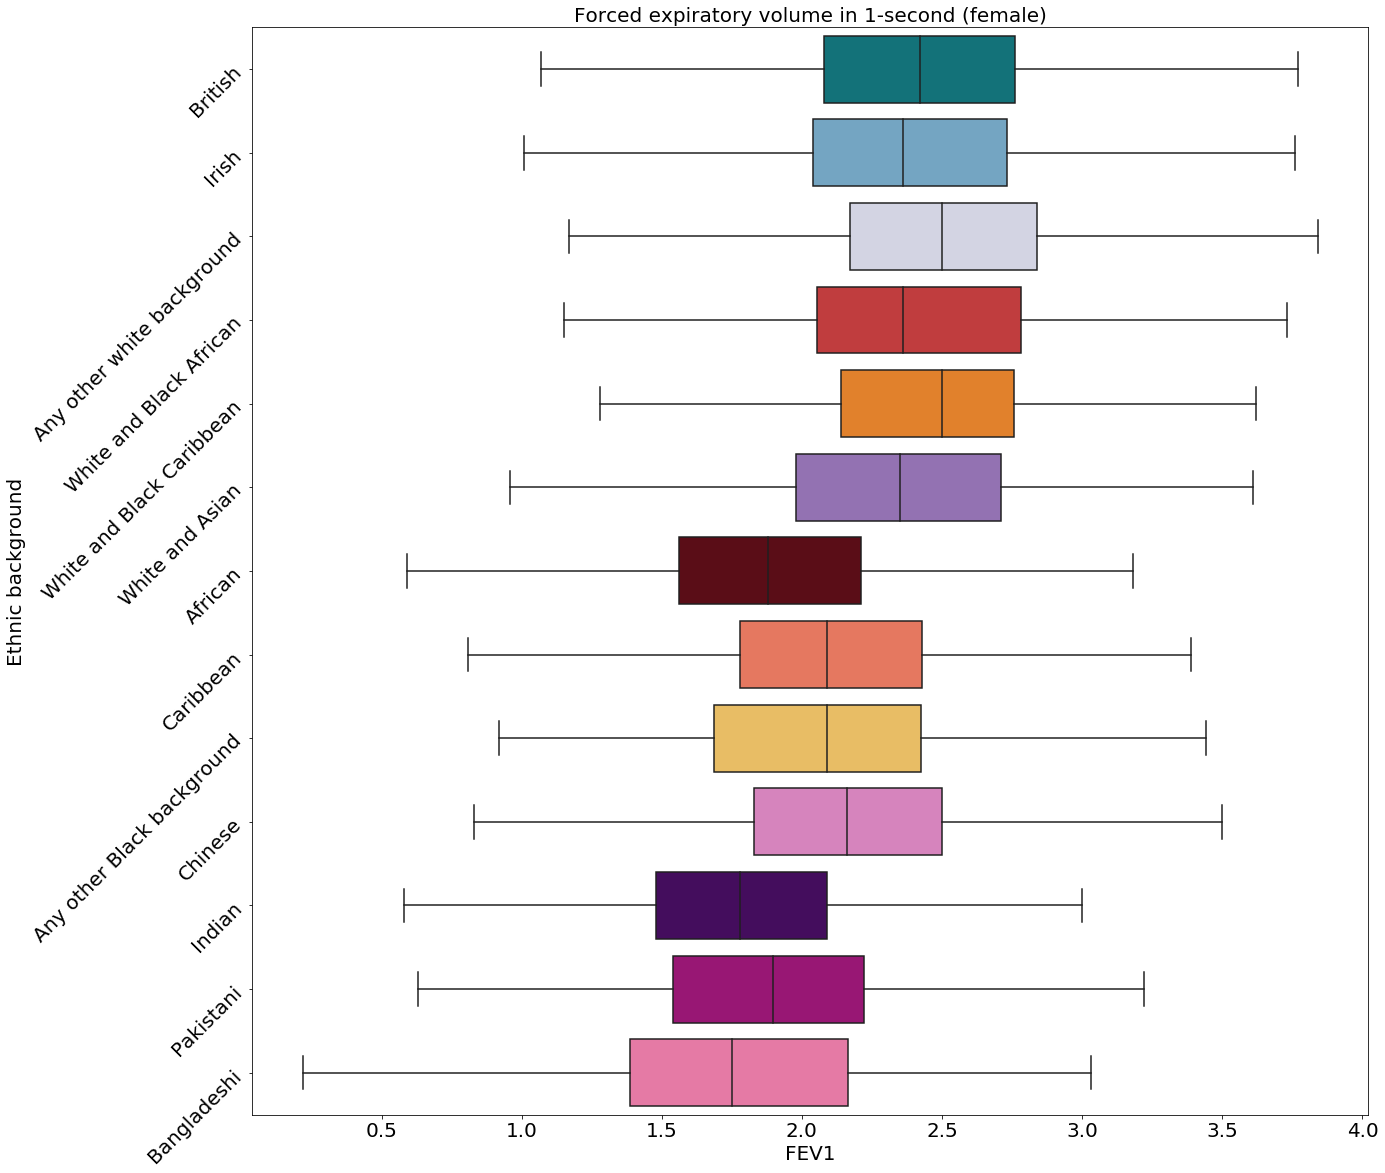

In [506]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(ax = ax, orient='h',
            palette = color_dict_ukbb,
            y = 'eth_txt',
            x = '3063_0_0',
            showfliers=False,
            order = ['British','Irish','Any other white background',
                     'White and Black African','White and Black Caribbean',
                     'White and Asian',
                     'African','Caribbean','Any other Black background',
                     'Chinese',
                     'Indian','Pakistani','Bangladeshi'],
           data = plot_fev_df_f)

#ax.text(5, 20, '*', ha='center', va='bottom',color='red')
ax.set_xlabel('FEV1')
ax.set_ylabel('Ethnic background')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_title('Forced expiratory volume in 1-second (female)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

# General phenotypes
We have the raw values for all phenotypes. Some of interest include:
* Leukocyte counts and percentages (file 7683, 30000.0-0)
* BMI (file 5602, 21001-0.0)

In [54]:
pheno_dir = '/Volumes/Stockage/alex/ukbb_phenos'

In [55]:
# Phenotype data is split among several different files
pheno_file = 'ukb7683.csv'

# Fields we wish to select
fields = ['eid','30000-0.0','30150-0.0','30160-0.0','30190-0.0','30120-0.0','30140-0.0']

# The names are uninformative so change them
fields_names = ['eid_blood','leukocyte_count','eosinophill_count','basophill_count','monocyte_pct','lymophocyte_count'\
               ,'neutrophill_count']

In [56]:
pheno_blood = pd.read_csv(os.path.join(pheno_dir, pheno_file), usecols=fields)
pheno_blood.columns=fields_names

In [57]:
# Also convert the IDs to strings for the eventual join
pheno_blood['eid_blood']=pheno_blood['eid_blood'].astype(str)

In [233]:
# BMI
pheno_file = 'ukb5602.csv'
fields = ['eid','21001-0.0']
fields_names = ['eid_bmi','bmi']

pheno_bmi = pd.read_csv(os.path.join(pheno_dir, pheno_file), usecols=fields)
pheno_bmi.columns=fields_names

pheno_bmi['eid_bmi'] = pheno_bmi['eid_bmi'].astype(str)

ukbb_pheno_joined_height_res_bmi = pd.merge(ukbb_pheno_joined_height_res, pheno_bmi, left_on='eid_str',
                                           right_on='eid_bmi',how='left')

In [234]:
ukbb_pheno_joined_height_res_bmi

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,sex,EID_age,age,FID_height_y,Height_res,Age_coeff,int,Height_age,eid_bmi,bmi
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,1,5806400,41.0,5806400,-0.796768,-0.137848,183.448530,182.651762,5806400,28.1528
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,0,2933933,46.0,2933933,2.026079,-0.146330,170.705124,172.731203,2933933,32.2979
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,0,3061593,52.0,3061593,-5.095938,-0.146330,170.705124,165.609186,3061593,20.3894
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,0,5051807,65.0,5051807,-3.193642,-0.146330,170.705124,167.511482,5051807,27.0790
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,0,4789231,56.0,4789231,2.989384,-0.146330,170.705124,173.694508,4789231,36.0347
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,1,1039230,50.0,1039230,9.443863,-0.137848,183.448530,192.892392,1039230,27.9512
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,0,3562010,41.0,3562010,-2.205574,-0.146330,170.705124,168.499550,3562010,23.0627
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,0,5851120,51.0,5851120,2.757731,-0.146330,170.705124,173.462855,5851120,19.7779
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,1,4712123,53.0,4712123,-9.142594,-0.137848,183.448530,174.305936,4712123,22.7330
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,0,4937825,50.0,4937825,-6.888599,-0.146330,170.705124,163.816525,4937825,24.9467


In [59]:
# Join to existing data frame. We can use ukbb_pheno_joined_height_res if it exists.
# Otherwise there's always ukbb_pheno_joined
ukbb_pheno_joined_height_res_blood = pd.merge(ukbb_pheno_joined_height_res,pheno_blood,left_on='eid_str',
                                              right_on='eid_blood',how='left')

In [60]:
ukbb_pheno_joined_height_res_blood

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,Age_coeff,int,Height_age,eid_blood,leukocyte_count,eosinophill_count,basophill_count,monocyte_pct,lymophocyte_count,neutrophill_count
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,-0.137848,183.448530,182.651762,5806400,7.39,1.84,4.69,0.46,0.03,5.34
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,-0.146330,170.705124,172.731203,2933933,10.61,2.99,7.05,0.11,0.05,3.90
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,-0.146330,170.705124,165.609186,3061593,5.82,1.84,3.46,0.08,0.07,6.35
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,-0.146330,170.705124,167.511482,5051807,7.22,1.74,4.91,0.04,0.03,7.00
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,-0.146330,170.705124,173.694508,4789231,8.38,2.78,4.36,0.74,0.03,5.61
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,-0.137848,183.448530,192.892392,1039230,4.78,1.53,2.74,0.16,0.02,6.81
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,-0.146330,170.705124,168.499550,3562010,8.32,1.74,6.08,0.14,0.03,4.08
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,-0.146330,170.705124,173.462855,5851120,6.96,2.11,4.16,0.08,0.04,8.27
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,-0.137848,183.448530,174.305936,4712123,5.69,1.83,3.44,0.08,0.02,5.71
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,-0.146330,170.705124,163.816525,4937825,6.75,1.68,4.50,0.12,0.04,6.01


Note: All units of measurement for cell counts are 10^9 cells/L

In [224]:
dset = ukbb_pheno_joined_height_res_blood
#plot_var = 'leukocyte_count'
plot_var = 'leukocyte_count'
caption = 'Leukocyte count (10^9 cells/L)'
percentile = 5

In [225]:
temp_list = dset[[plot_var,'sex']].values.tolist()
temp_list_m = [t[0] for t in temp_list if t[1]=='1']
temp_list_f = [t[0] for t in temp_list if t[1]=='0']

females = dset[dset.loc[:,'sex'] == '0']
males = dset[dset.loc[:,'sex'] == '1']

indices_of_population_sex = defaultdict(list)

indices_of_population_sex['0'] = females.index.tolist()
indices_of_population_sex['1'] = males.index.tolist()

dset_list_f = females[plot_var].values.tolist()
dset_list_m = males[plot_var].values.tolist()

temp_colours_f = []
temp_colours_m = []
temp_alpha_f = []
temp_alpha_m = []

min_m = np.nanpercentile(np.array(temp_list_m), percentile)
max_m = np.nanpercentile(np.array(temp_list_m), 100-percentile)
min_f = np.nanpercentile(np.array(temp_list_f), percentile)
max_f = np.nanpercentile(np.array(temp_list_f), 100-percentile)

alpha_vals = 0.6
print('Min (M): ' + str(min_m))
print('Max (M): ' + str(max_m))
print('Min (F): ' + str(min_f))
print('Min (F): ' + str(max_f))

Min (M): 4.42
Max (M): 10.1
Min (F): 4.4
Min (F): 10.0


In [226]:
np.nanmax(females[plot_var].values)

138.69999999999999

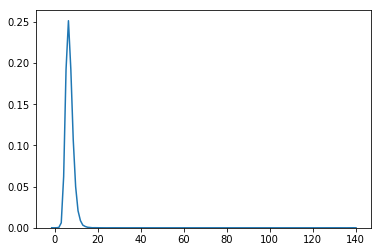

In [227]:
#plt.hist(females[plot_var].values[~np.isnan(females[plot_var].values)])
sns.kdeplot(females[plot_var].values[~np.isnan(females[plot_var].values)],cut=10)

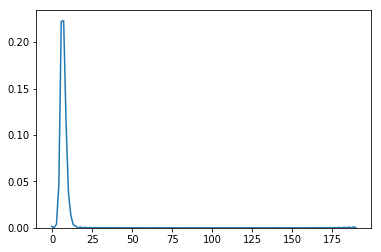

In [228]:
sns.kdeplot(males[plot_var].values[~np.isnan(males[plot_var].values)])

In [229]:
# Prepare the colouring (females)
for h in dset_list_f:
    # Unknown value - make it transparent and add an arbitrary value
    if np.isnan(h):
        temp_colours_f.append(np.mean([min_f, max_f]))
        temp_alpha_f.append(0)
    elif h < min_f:
        temp_colours_f.append(min_f)
        temp_alpha_f.append(alpha_vals)
    elif h > max_f:
        temp_colours_f.append(max_f)
        temp_alpha_f.append(alpha_vals)
    else:
        temp_colours_f.append(h)
        temp_alpha_f.append(alpha_vals)

norm_f = matplotlib.colors.Normalize(vmin=min_f, vmax=max_f, clip=False)
mapper_f = cm.ScalarMappable(norm=norm_f, cmap=cm.coolwarm)

colours_f = []
    
for i in range(0, len(temp_colours_f)):
    colours_f.append(mapper_f.to_rgba(temp_colours_f[i], alpha=temp_alpha_f[i]))
    
mapper_f_temp = mapper_f
mapper_f_temp._A = []

# Prepare the colouring (males)
for h in dset_list_m:
    # Unknown value - make it transparent and add an arbitrary value
    if np.isnan(h):
        temp_colours_m.append(np.mean([min_m, max_m]))
        temp_alpha_m.append(0)
    elif h < min_m:
        temp_colours_m.append(min_m)
        temp_alpha_m.append(alpha_vals)
    elif h > max_m:
        temp_colours_m.append(max_m)
        temp_alpha_m.append(alpha_vals)
    else:
        temp_colours_m.append(h)
        temp_alpha_m.append(alpha_vals)

norm_m = matplotlib.colors.Normalize(vmin=min_m, vmax=max_m, clip=False)
mapper_m = cm.ScalarMappable(norm=norm_m, cmap=cm.coolwarm)

colours_m = []
    
for i in range(0, len(temp_colours_m)):
    colours_m.append(mapper_m.to_rgba(temp_colours_m[i], alpha=temp_alpha_m[i]))
    
mapper_m_temp = mapper_m
mapper_m_temp._A = []

In [230]:
# One-offs
proj_dir = '/Volumes/Stockage/alex/ukbb_projections/'
out_dir = '/Volumes/Stockage/alex/ukbb_images/one_off'
fname = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'
size = 20
fsize = 40 #font size

proj=np.loadtxt(os.path.join(proj_dir,fname))

# Female heights
temp_proj = proj[indices_of_population_sex['0']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_f, cmap=cm.coolwarm, s=size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_f_temp,orientation='horizontal',cax=cax)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(caption,size=fsize)

fig.savefig(os.path.join(out_dir, fname+'_'+plot_var+'_pct'+str(percentile)+'_f.jpeg'),format='jpeg')
plt.close()

# Male heights
temp_proj = proj[indices_of_population_sex['1']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_m, cmap=cm.coolwarm, s=size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_m_temp,orientation='horizontal',cax=cax)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(caption,size=fsize)

fig.savefig(os.path.join(out_dir, fname+'_'+plot_var+'_pct'+str(percentile)+'_m.jpeg'),format='jpeg')
plt.close()

In [61]:
# Plot leukocyte count against age (do sex-specific)
temp = ukbb_pheno_joined_height_res_blood.loc[ukbb_pheno_joined_height_res_blood.sex=='1']

In [70]:
# Leukocyte count appears to increase linearly by age
temp.groupby('age').agg({'leukocyte_count':'mean'})

,leukocyte_count
age,
37.0,8.240000
38.0,7.000000
39.0,6.567500
40.0,6.649386
41.0,6.601475
42.0,6.674112
43.0,6.667583
44.0,6.709541
45.0,6.697059


## Manuscript additions
Do some statistical testing of other phenotypes. Specifically:
* Eosinophill count (South Asians are higher than average)
* Basophill count (Black African/Black Caribbean much lower than average, Chinese/East Asian lower than average)
* FEV (Black African, Black Caribbean, South Asian much lower than average. Chinese slightly lower. Some "other" (East Asian??) ethnicity also noticably lower)
* Neutrophill count (South Asian, East Asian somewhat lower). Admixed-African appears lower with less signal from Black African/Caribbean)
* Leukocyte count (Black African/Caribbean, Chinese/East Asian lower than average, South Asian higher than average)

In [364]:
ukbb_eth_df = pd.DataFrame(list(ukbb_eth_dict.items()), columns=['eth_code','eth_txt'])

#ukbb_eth_df = pd.Series(ukbb_eth_dict, name='eth_txt')
#ukbb_eth_df.index.name = 'eth_code'
#ukbb_eth_df.reset_index()

In [366]:
# Join text description of ethnicity
ukbb_pheno_joined_height_res_blood_2 = pd.merge(ukbb_pheno_joined_height_res_blood, ukbb_eth_df, left_on='eth1_str', \
                                              right_on='eth_code', how='left')

In [367]:
ukbb_pheno_joined_height_res_blood_2

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,Height_age,eid_blood,leukocyte_count,eosinophill_count,basophill_count,monocyte_pct,lymophocyte_count,neutrophill_count,eth_code,eth_txt
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,182.651762,5806400,7.39,1.84,4.69,0.46,0.03,5.34,1001,British
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,172.731203,2933933,10.61,2.99,7.05,0.11,0.05,3.90,1001,British
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,165.609186,3061593,5.82,1.84,3.46,0.08,0.07,6.35,1001,British
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,167.511482,5051807,7.22,1.74,4.91,0.04,0.03,7.00,1001,British
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,173.694508,4789231,8.38,2.78,4.36,0.74,0.03,5.61,1001,British
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,192.892392,1039230,4.78,1.53,2.74,0.16,0.02,6.81,1001,British
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,168.499550,3562010,8.32,1.74,6.08,0.14,0.03,4.08,1001,British
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,173.462855,5851120,6.96,2.11,4.16,0.08,0.04,8.27,1001,British
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,174.305936,4712123,5.69,1.83,3.44,0.08,0.02,5.71,1001,British
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,163.816525,4937825,6.75,1.68,4.50,0.12,0.04,6.01,1001,British


In [311]:
ukbb_eth_dict

{'-1': 'Do not know',
 '-3': 'Prefer not to answer',
 '-9': 'Not available',
 '1': 'White',
 '1001': 'British',
 '1002': 'Irish',
 '1003': 'Any other white background',
 '2': 'Mixed',
 '2001': 'White and Black Caribbean',
 '2002': 'White and Black African',
 '2003': 'White and Asian',
 '2004': 'Any other mixed background',
 '3': 'Asian or Asian British',
 '3001': 'Indian',
 '3002': 'Pakistani',
 '3003': 'Bangladeshi',
 '3004': 'Any other Asian background',
 '4': 'Black or Black British',
 '4001': 'Caribbean',
 '4002': 'African',
 '4003': 'Any other Black background',
 '5': 'Chinese',
 '6': 'Other ethnic group'}

In [312]:
ba = ukbb_pheno_joined_height_res_blood.loc[(ukbb_pheno_joined_height_res_blood['eth1_str']=='4002')]
ba_f = ba.loc[ba['sex']=='0']
ba_m = ba.loc[ba['sex']=='1']

In [313]:
brit = ukbb_pheno_joined_height_res_blood.loc[(ukbb_pheno_joined_height_res_blood['eth1_str']=='1001')]
brit_f = brit.loc[brit['sex']=='0']
brit_m = brit.loc[brit['sex']=='1']

In [317]:
# Look at female leukocyte counts
var = 'leukocyte_count'

print(ttest_ind(ba_f[var], brit_f[var], nan_policy='omit'))
print(ttest_ind(ba_m[var], brit_m[var], nan_policy='omit'))

Ttest_indResult(statistic=-24.567164217489452, pvalue=4.2355851031254347e-133)
Ttest_indResult(statistic=-27.149309604058036, pvalue=5.1967614053247734e-162)


In [335]:
color_dict_ukbb

{'African': '#67000d',
 'Any other Asian background': '#fcc5c0',
 'Any other Black background': '#fec44f',
 'Any other mixed background': '#2ca02c',
 'Any other white background': '#d0d1e6',
 'Asian or Asian British': '#3f007d',
 'Bangladeshi': '#f768a1',
 'Black or Black British': '#fe9929',
 'British': '#02818a',
 'Caribbean': '#fb6a4a',
 'Chinese': '#e377c2',
 'Do not know': '#969696',
 'Indian': '#49006a',
 'Irish': '#67a9cf',
 'Mixed': '#00441b',
 'Not available': '#d9d9d9',
 'Other ethnic group': '#636363',
 'Pakistani': '#ae017e',
 'Prefer not to answer': '#bdbdbd',
 'White': '#014636',
 'White and Asian': '#9467bd',
 'White and Black African': '#d62728',
 'White and Black Caribbean': '#ff7f0e'}

In [373]:
# Split our dataset by sex
plot_df_f = ukbb_pheno_joined_height_res_blood_2.loc[(ukbb_pheno_joined_height_res_blood_2['sex']=='0')]
plot_df_m = ukbb_pheno_joined_height_res_blood_2.loc[(ukbb_pheno_joined_height_res_blood_2['sex']=='1')]

In [426]:
# WLOG work on the dataset of females (more samples) and split by self-identified ethnic background
plt_df_f_bri = plot_df_f.loc[(plot_df_f['eth_txt']=='British')]
plt_df_f_iri = plot_df_f.loc[(plot_df_f['eth_txt']=='Irish')]
plt_df_f_awb = plot_df_f.loc[(plot_df_f['eth_txt']=='Any other white background')]
plt_df_f_afr = plot_df_f.loc[(plot_df_f['eth_txt']=='African')]
plt_df_f_car = plot_df_f.loc[(plot_df_f['eth_txt']=='Caribbean')]
plt_df_f_chi = plot_df_f.loc[(plot_df_f['eth_txt']=='Chinese')]
plt_df_f_ban = plot_df_f.loc[(plot_df_f['eth_txt']=='Bangladeshi')]
plt_df_f_ind = plot_df_f.loc[(plot_df_f['eth_txt']=='Indian')]
plt_df_f_pak = plot_df_f.loc[(plot_df_f['eth_txt']=='Pakistani')]
plt_df_f_abb = plot_df_f.loc[(plot_df_f['eth_txt']=='Any other black background')]
plt_df_f_wba = plot_df_f.loc[(plot_df_f['eth_txt']=='White and Black African')]
plt_df_f_wbc = plot_df_f.loc[(plot_df_f['eth_txt']=='White and Black Caribbean')]
plt_df_f_wba = plot_df_f.loc[(plot_df_f['eth_txt']=='White and Asian')]
plt_df_f_aab = plot_df_f.loc[(plot_df_f['eth_txt']=='Any other Asian background')]
plt_df_f_amb = plot_df_f.loc[(plot_df_f['eth_txt']=='Any other mixed background')]

In [434]:
?ttest_ind

In [437]:
0.5/22

0.022727272727272728

In [435]:
# Run the paired t-tests
var = 'leukocyte_count'
#print(ttest_ind(plt_df_f_bri[var], plt_df_f_afr[var], nan_policy='omit'))
print(ttest_ind(plt_df_f_bri[var], plt_df_f_ban[var], nan_policy='omit'))

Ttest_indResult(statistic=-5.4253223968022448, pvalue=5.7909244687610386e-08)


In [430]:
# Run ANOVA since we need something better than a bunch of pairwise t-tests
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('basophill_count ~ eth1_str', data=plot_df_f).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)

/Users/alex/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [431]:
print(aov_table)

                 sum_sq        df           F  PR(>F)
eth1_str    4851.363312      22.0  114.293197     0.0
Residual  493170.257957  255609.0         NaN     NaN


In [449]:
# Tukey's HSD (overkill - I'm not comparing 22 populations pairwise)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [454]:
type(plot_df_f['eth_txt'].values)

numpy.ndarray

In [457]:
temp = plot_df_f.iloc[~np.isnan(plot_df_f.leukocyte_count.values)]

In [464]:
tukey = pairwise_tukeyhsd(endog=temp['leukocyte_count'].values,
                         groups=temp['eth_txt'].values,
                         alpha=0.05)

In [465]:
tukey.summary()

group1,group2,meandiff,lower,upper,reject
African,Any other Asian background,1.597,1.2875,1.9065,True
African,Any other Black background,0.6021,-0.2326,1.4368,False
African,Any other mixed background,1.3617,1.028,1.6955,True
African,Any other white background,1.1854,0.9904,1.3803,True
African,Asian or Asian British,1.0988,-0.4577,2.6552,False
African,Bangladeshi,2.5607,1.671,3.4504,True
African,Black or Black British,0.398,-1.3398,2.1358,False
African,British,1.244,1.062,1.426,True
African,Caribbean,0.4399,0.2129,0.667,True
African,Chinese,0.5611,0.2686,0.8536,True


In [405]:
?sns.boxplot

In [536]:
temp = plot_df_f.iloc[~np.isnan(plot_df_f.basophill_count.values)]
tukey = pairwise_tukeyhsd(endog=temp['basophill_count'].values,
                         groups=temp['eth_txt'].values,
                         alpha=0.05)
tukey.summary()

group1,group2,meandiff,lower,upper,reject
African,Any other Asian background,1.2491,1.0238,1.4744,True
African,Any other Black background,0.5752,-0.0313,1.1816,False
African,Any other mixed background,1.3216,1.079,1.5641,True
African,Any other white background,1.2213,1.0795,1.3631,True
African,Asian or Asian British,0.982,-0.1488,2.1127,False
African,Bangladeshi,1.9762,1.3248,2.6275,True
African,Black or Black British,0.2236,-1.039,1.4861,False
African,British,1.2551,1.1228,1.3875,True
African,Caribbean,0.3574,0.1923,0.5226,True
African,Chinese,0.8005,0.5879,1.0131,True


In [533]:
?tukey.summary()

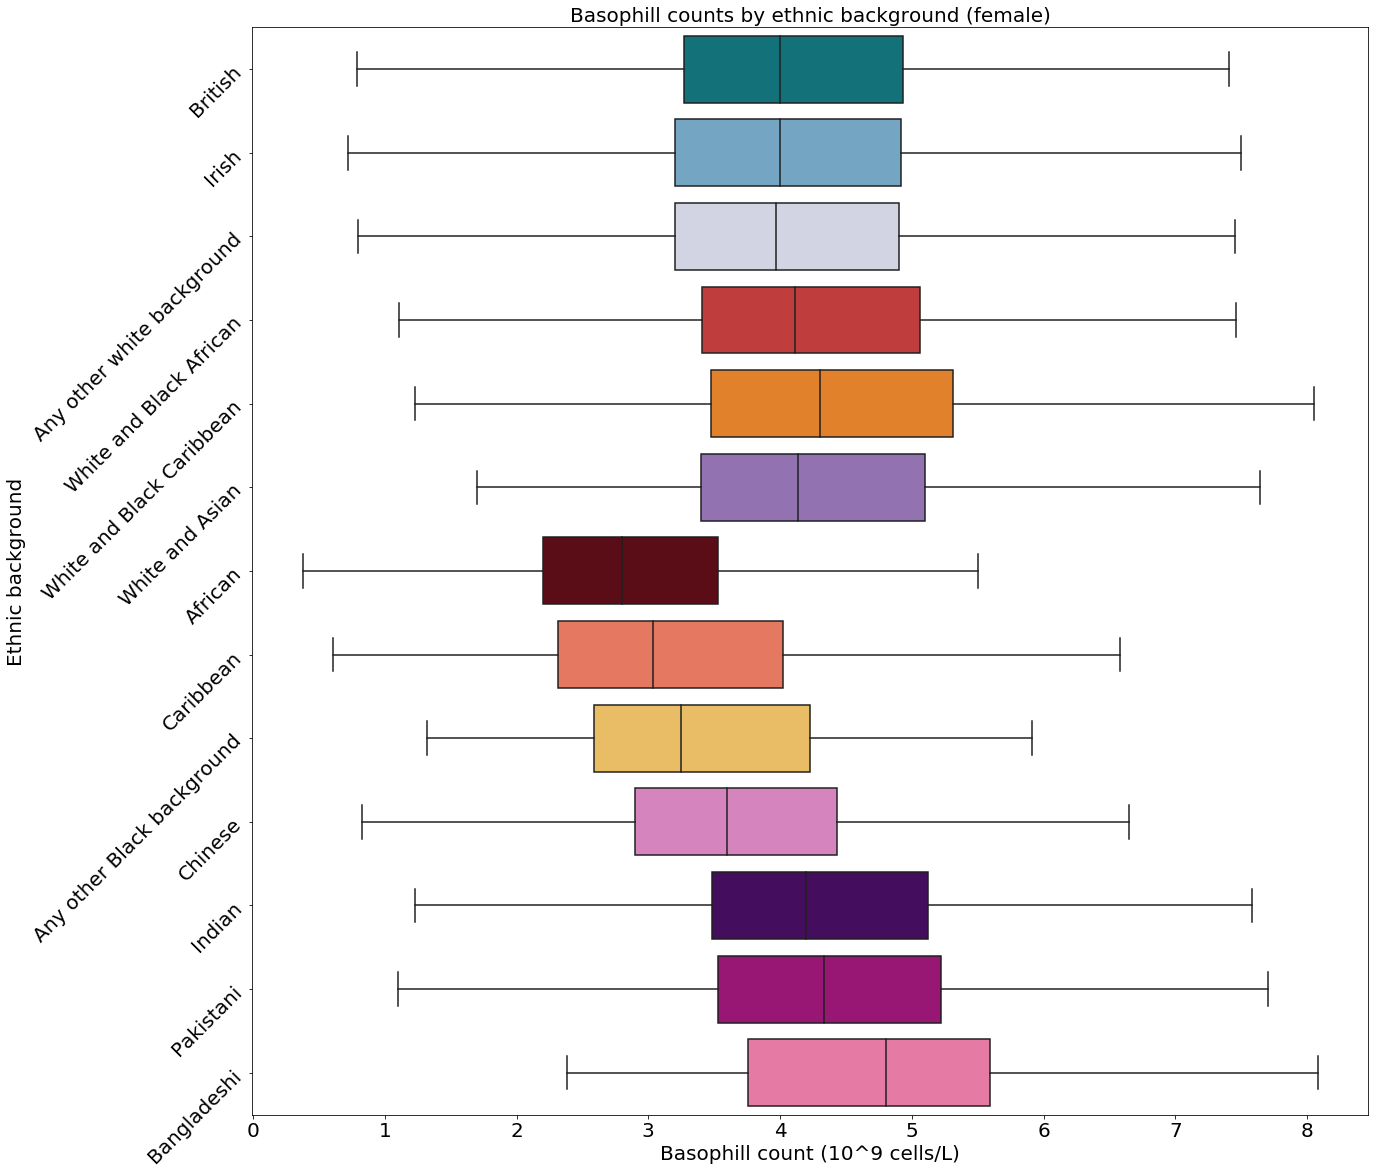

In [497]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(ax = ax, orient='h',
            palette = color_dict_ukbb,
            y = 'eth_txt',
            x = 'basophill_count',
            showfliers=False,
            order = ['British','Irish','Any other white background',
                     'White and Black African','White and Black Caribbean',
                     'White and Asian',
                     'African','Caribbean','Any other Black background',
                     'Chinese',
                     'Indian','Pakistani','Bangladeshi'],
           data = plot_df_f)

#ax.text(5, 20, '*', ha='center', va='bottom',color='red')
ax.set_xlabel('Basophill count (10^9 cells/L)')
ax.set_ylabel('Ethnic background')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_title('Basophill counts by ethnic background (female)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

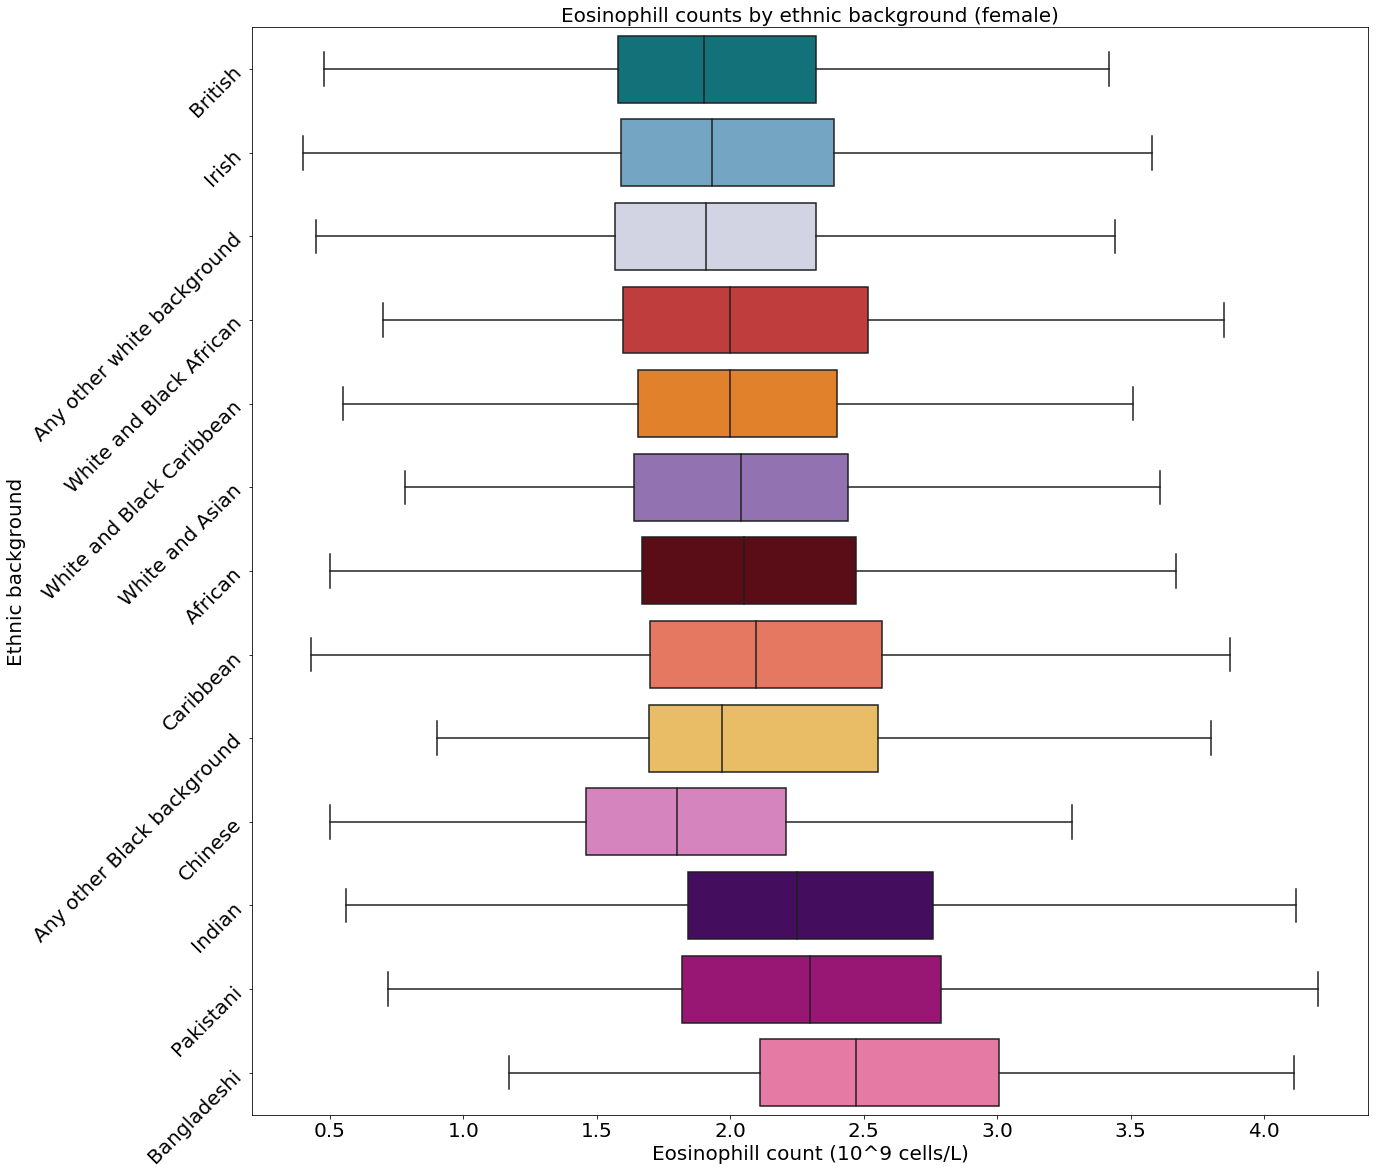

In [472]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(ax = ax, orient='h',
            palette = color_dict_ukbb,
            y = 'eth_txt',
            x = 'eosinophill_count',
            showfliers=False,
            order = ['British','Irish','Any other white background',
                     'White and Black African','White and Black Caribbean',
                     'White and Asian',
                     'African','Caribbean','Any other Black background',
                     'Chinese',
                     'Indian','Pakistani','Bangladeshi'],
           data = plot_df_f)

ax.set_xlabel('Eosinophill count (10^9 cells/L)')
ax.set_ylabel('Ethnic background')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_title('Eosinophill counts by ethnic background (female)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

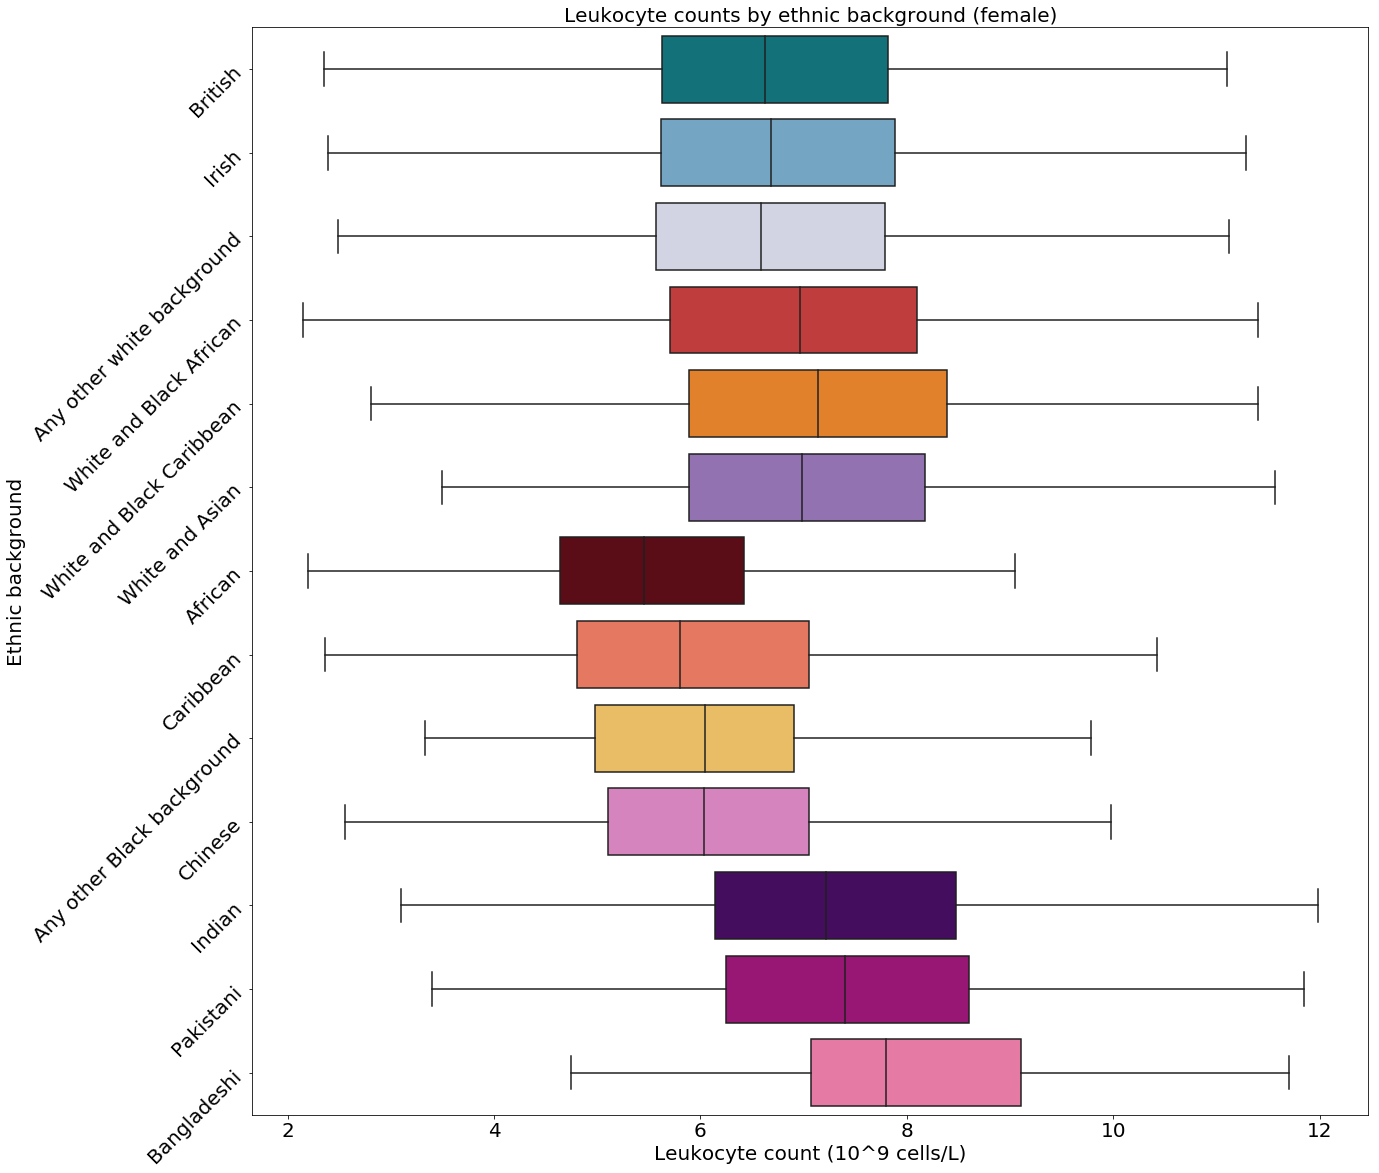

In [470]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(ax = ax, orient='h',
            palette = color_dict_ukbb,
            y = 'eth_txt',
            x = 'leukocyte_count',
            showfliers=False,
            order = ['British','Irish','Any other white background',
                     'White and Black African','White and Black Caribbean',
                     'White and Asian',
                     'African','Caribbean','Any other Black background',
                     'Chinese',
                     'Indian','Pakistani','Bangladeshi'],
           data = plot_df_f)

ax.set_xlabel('Leukocyte count (10^9 cells/L)')
ax.set_ylabel('Ethnic background')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_title('Leukocyte counts by ethnic background (female)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

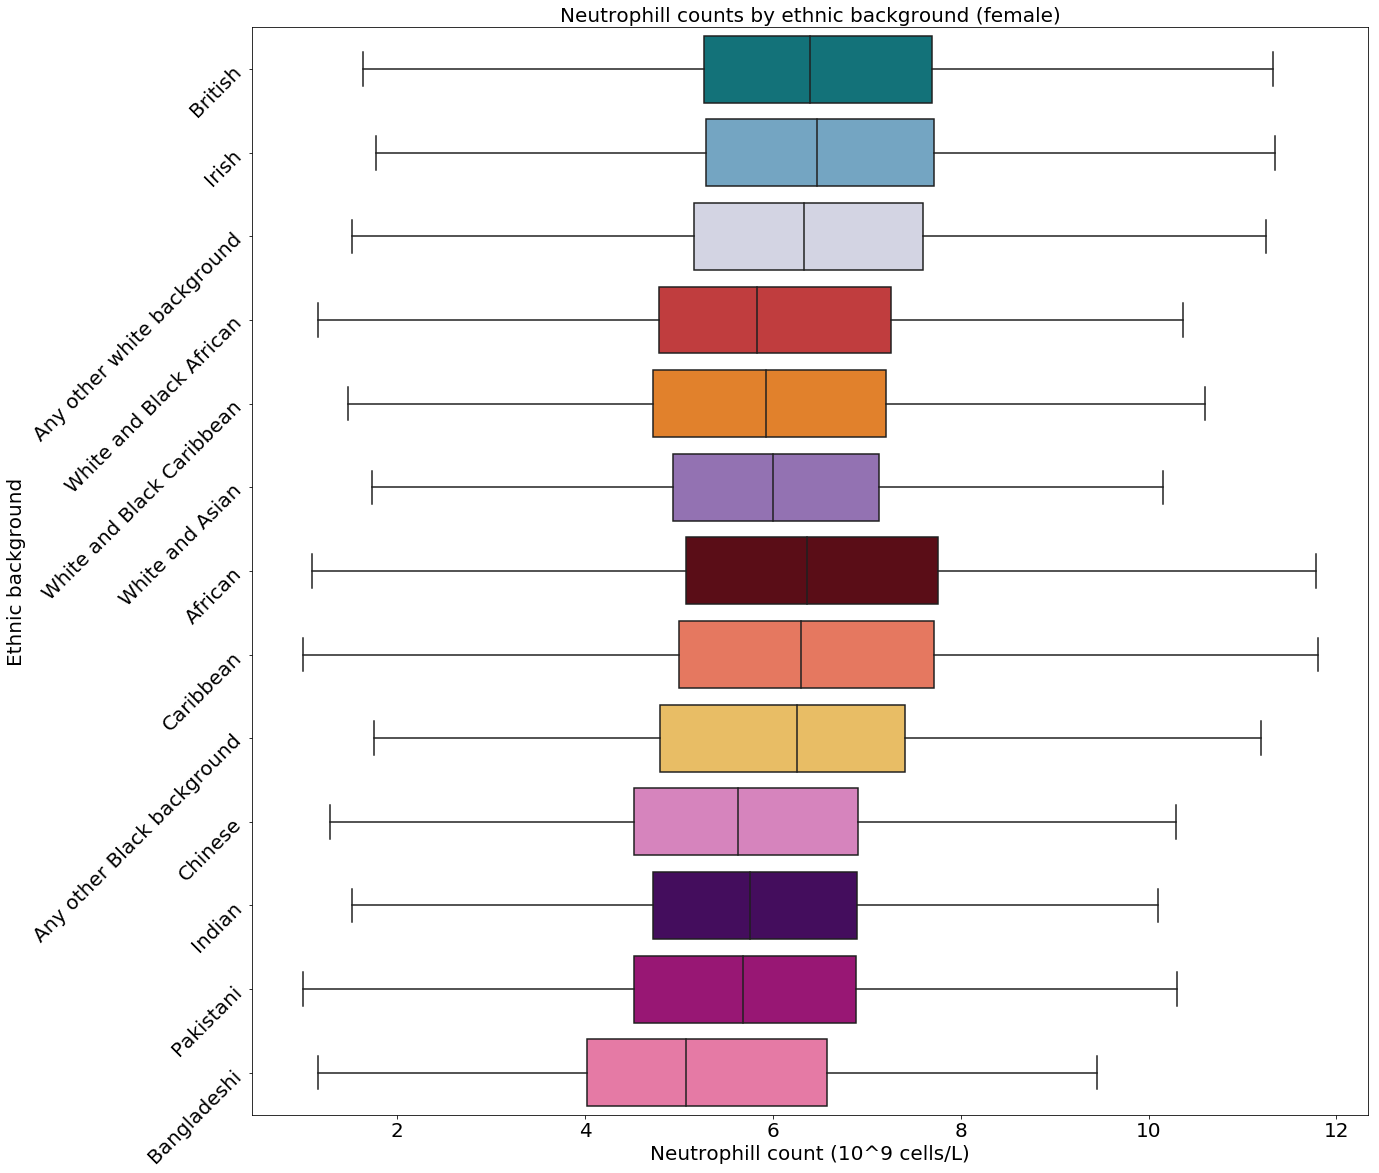

In [473]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(ax = ax, orient='h',
            palette = color_dict_ukbb,
            y = 'eth_txt',
            x = 'neutrophill_count',
            showfliers=False,
            order = ['British','Irish','Any other white background',
                     'White and Black African','White and Black Caribbean',
                     'White and Asian',
                     'African','Caribbean','Any other Black background',
                     'Chinese',
                     'Indian','Pakistani','Bangladeshi'],
           data = plot_df_f)

ax.set_xlabel('Neutrophill count (10^9 cells/L)')
ax.set_ylabel('Ethnic background')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_title('Neutrophill counts by ethnic background (female)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

In [ ]:
# For reference: Splitting PD datasets
irish = ukbb_pheno_joined_height_res.loc[(ukbb_pheno_joined_height_res['eth1_str']=='1002')]
irish = irish.loc[np.abs(irish['Height_res']) < 25]
irish_female = irish.loc[irish['sex']=='0']

In [ ]:
# For reference: t-test code
print(ttest_ind(irish_female['Height_res'], british_female['Height_res']))
print(ttest_ind(irish_male['Height_res'], british_male['Height_res']))

In [ ]:
# for reference: boxplot code
plt.figure(figsize=(20,20))
labels = ['British','Irish']
ax = plt.subplot(111, xlabel='Ethnic background', ylabel='Age-adjusted height difference from mean (cm)')
plt.boxplot((british_female['Height_res'].values, irish_female['Height_res'].values), labels=labels, widths=0.9)
plt.title('Height difference in females by ethnic background')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.savefig('/Volumes/Stockage/alex/ukbb_images/other/female_height_irish_british_boxplot.jpeg')

# Phenotypes (old)

In [35]:
pheno_dir = '/Users/alex/Documents/Ethnicity/UKBB_pheno'
height_file = 'Height.pheno'
covar_file = 'ukb4940.csv'

In [36]:
# File of covariates
ukbb_covar = pd.read_csv(os.path.join(pheno_dir, covar_file))[['eid','31-0.0']]
ukbb_covar.columns = ['eid_covar', 'sex'] # (0 = F, 1 = M)
ukbb_covar['eid_covar']=ukbb_covar['eid_covar'].astype(str)
ukbb_covar['sex']=ukbb_covar['sex'].astype(str)

In [37]:
ukbb_covar

,eid_covar,sex
0,3341191,1
1,4316233,0
2,5682501,0
3,2605007,0
4,2537402,0
5,5336616,0
6,1270574,0
7,2503395,1
8,3020054,0
9,2854838,0


In [38]:
# Read in the UKBB height phenotype data. We need to join this to the main UKBB dataset to get indexing right.
ukbb_pheno_height = pd.read_csv(os.path.join(pheno_dir,height_file), sep=' ')
ukbb_pheno_height['FID']=ukbb_pheno_height['FID'].astype(str)
ukbb_pheno_height['IID']=ukbb_pheno_height['IID'].astype(str)

ukbb_pheno_height.columns=['FID_height','IID_height','Height']

In [39]:
ukbb_pheno_height

,FID_height,IID_height,Height
0,3434858,3434858,184.0
1,2757738,2757738,158.0
2,5034292,5034292,156.0
3,5869043,5869043,159.0
4,4517184,4517184,161.0
5,4029577,4029577,172.0
6,4000629,4000629,165.0
7,4039074,4039074,161.5
8,5710337,5710337,169.0
9,3007095,3007095,181.0


In [40]:
ukbb_pheno_joined = ukbb_df_joined2.merge(ukbb_pheno_height, left_on='IID', right_on='IID_height', how='left')
ukbb_pheno_joined = ukbb_pheno_joined.merge(ukbb_covar, left_on='IID',right_on='eid_covar', how='left')

In [41]:
ukbb_pheno_age = pd.read_csv('/Users/alex/Documents/Ethnicity/UKBB_pheno/ukb4940.csv')[['eid','21003-0.0']]
ukbb_pheno_age.columns=['EID_age','age']
ukbb_pheno_age['EID_age']=ukbb_pheno_age['EID_age'].astype(str)
ukbb_pheno_age['age'] = ukbb_pheno_age['age'].fillna(0)

In [42]:
np.min(ukbb_pheno_age.age), np.max(ukbb_pheno_age.age)

(37, 73)

In [43]:
ukbb_pheno_joined = ukbb_pheno_joined.merge(ukbb_pheno_age, left_on='FID',right_on='EID_age', how='left')

In [44]:
ukbb_pheno_joined

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,eid_str_geo,northing_filled,easting_filled,FID_height,IID_height,Height,eid_covar,sex,EID_age,age
0,5806400,5806400,5806400.0,1001.0,1001.0,5806400,1001,1001,5806400.0,1.0,...,5806400,0.0,0.0,5806400,5806400,177.0,5806400,1,5806400,41.0
1,2933933,2933933,2933933.0,1001.0,1001.0,2933933,1001,1001,2933933.0,1.0,...,2933933,271500.0,429500.0,2933933,2933933,166.0,2933933,0,2933933,46.0
2,3061593,3061593,3061593.0,1001.0,1001.0,3061593,1001,1001,3061593.0,1.0,...,3061593,392500.0,335500.0,3061593,3061593,158.0,3061593,0,3061593,52.0
3,5051807,5051807,5051807.0,1001.0,1001.0,5051807,1001,1001,5051807.0,1.0,...,5051807,222500.0,458500.0,5051807,5051807,158.0,5051807,0,5051807,65.0
4,4789231,4789231,4789231.0,1001.0,1001.0,4789231,1001,1001,4789231.0,1.0,...,4789231,187500.0,556500.0,4789231,4789231,165.5,4789231,0,4789231,56.0
5,1039230,1039230,1039230.0,1001.0,1001.0,1039230,1001,1001,1039230.0,NaN,...,1039230,171500.0,339500.0,1039230,1039230,186.0,1039230,1,1039230,50.0
6,3562010,3562010,3562010.0,1001.0,1001.0,3562010,1001,1001,3562010.0,1.0,...,3562010,120500.0,314500.0,3562010,3562010,162.5,3562010,0,3562010,41.0
7,5851120,5851120,5851120.0,1001.0,1001.0,5851120,1001,1001,5851120.0,1.0,...,5851120,166500.0,340500.0,5851120,5851120,166.0,5851120,0,5851120,51.0
8,4712123,4712123,4712123.0,1001.0,1001.0,4712123,1001,1001,4712123.0,1.0,...,4712123,384500.0,433500.0,4712123,4712123,167.0,4712123,1,4712123,53.0
9,4937825,4937825,4937825.0,1001.0,1001.0,4937825,1001,1001,4937825.0,1.0,...,4937825,424500.0,381500.0,4937825,4937825,156.5,4937825,0,4937825,50.0


In [ ]:
# There's some bad data here
np.where(pd.isnull(ukbb_pheno_joined[['sex']]))

In [194]:
ukbb_pheno_joined.iloc[[68758,127546,409932]]

,FID,IID,eid_x,eth1,eth2,eid_str,eth1_str,eth2_str,eid_y,genetic_grouping,...,eid_str_geo,northing_filled,easting_filled,FID_height,IID_height,Height,eid_covar,sex,EID_age,age
68758,-1,-1,NaN,NaN,NaN,NaN,-9,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127546,-2,-2,NaN,NaN,NaN,NaN,-9,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409932,-3,-3,NaN,NaN,NaN,NaN,-9,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
# Set up our lists, indices, and parameters
females = ukbb_pheno_joined[ukbb_pheno_joined.loc[:,'sex'] == '0']
males = ukbb_pheno_joined[ukbb_pheno_joined.loc[:,'sex'] == '1']

indices_of_population_sex = defaultdict(list)

indices_of_population_sex['0'] = females.index.tolist()
indices_of_population_sex['1'] = males.index.tolist()

height_list_f = females['Height'].values.tolist()
height_list_m = males['Height'].values.tolist()

temp_colours_f = []
temp_colours_m = []
temp_alpha_f = []
temp_alpha_m = []

min_m = np.percentile(np.array(temp_list_m), 1)
max_m = np.percentile(np.array(temp_list_m), 99)
min_f = np.percentile(np.array(temp_list_f), 1)
max_f = np.percentile(np.array(temp_list_f), 99)

alpha_vals = 0.6

In [215]:
# Prepare the data for output (females)
for h in height_list_f:
    # Unknown height - make it transparent and add an arbitrary value
    if h < 0:
        temp_colours_f.append(np.mean([min_f, max_f]))
        temp_alpha_f.append(0)
    elif h < min_f:
        temp_colours_f.append(min_f)
        temp_alpha_f.append(alpha_vals)
    elif h > max_f:
        temp_colours_f.append(max_f)
        temp_alpha_f.append(alpha_vals)
    else:
        temp_colours_f.append(h)
        temp_alpha_f.append(alpha_vals)

norm_f = matplotlib.colors.Normalize(vmin=min_f, vmax=max_f, clip=False)
mapper_f = cm.ScalarMappable(norm=norm_f, cmap=cm.coolwarm)

colours_f = []
    
for i in range(0, len(temp_colours_f)):
    colours_f.append(mapper_f.to_rgba(temp_colours_f[i], alpha=temp_alpha_f[i]))
    
mapper_f_temp = mapper_f
mapper_f_temp._A = []

# Prepare the data for output (males)
for h in height_list_m:
    # Unknown height - make it transparent and add an arbitrary value
    if h < 0:
        temp_colours_m.append(np.mean([min_m, max_m]))
        temp_alpha_m.append(0)
    elif h < min_m:
        temp_colours_m.append(min_m)
        temp_alpha_m.append(alpha_vals)
    elif h > max_m:
        temp_colours_m.append(max_m)
        temp_alpha_m.append(alpha_vals)
    else:
        temp_colours_m.append(h)
        temp_alpha_m.append(alpha_vals)

norm_m = matplotlib.colors.Normalize(vmin=min_m, vmax=max_m, clip=False)
mapper_m = cm.ScalarMappable(norm=norm_m, cmap=cm.coolwarm)

colours_m = []
    
for i in range(0, len(temp_colours_m)):
    colours_m.append(mapper_m.to_rgba(temp_colours_m[i], alpha=temp_alpha_m[i]))
    
mapper_m_temp = mapper_m
mapper_m_temp._A = []

In [216]:
# Output
proj_dir = '/Volumes/Stockage/alex/ukbb_projections/'
out_dir = '/Volumes/Stockage/alex/ukbb_images/height/test'
fname = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'

proj=np.loadtxt(os.path.join(proj_dir,fname))

# Female heights
temp_proj = proj[indices_of_population_sex['0']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_f, cmap=cm.coolwarm, s=7)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_f_temp,orientation='horizontal',cax=cax)
cbar.set_label('Height (cm)')

fig.savefig(os.path.join(out_dir, fname+'_height_f.jpeg'),format='jpeg')
plt.close()

temp_proj = proj[indices_of_population_sex['1']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_m, cmap=cm.coolwarm, s=7)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_m_temp,orientation='horizontal',cax=cax)
cbar.set_label('Height (cm)')

fig.savefig(os.path.join(out_dir, fname+'_height_m.jpeg'),format='jpeg')
plt.close()

In [170]:
# Get the indices of members of the sexes:
sex_list = ukbb_pheno_joined['sex'].values.tolist()

In [171]:
height_list = ukbb_pheno_joined[['Height','sex']].values.tolist()

In [172]:
indices_of_population_sex = defaultdict(list)

for sex in ['0','1']:
    temp_list = ukbb_pheno_joined[ukbb_pheno_joined['sex']==sex].index.values.tolist()
    indices_of_population_sex[sex] = temp_list

In [127]:
# Need to create colour coding relative to each of the sexes
temp_colours_m = []
temp_colours_f = []
temp_alpha_m = []
temp_alpha_f = []

min_m = 140
max_m = 210
min_f = 130
max_f = 190
#min_m = np.percentile(np.array(temp_list_m), 1)
#max_m = np.percentile(np.array(temp_list_m), 99)
#min_f = np.percentile(np.array(temp_list_f), 1)
#max_f = np.percentile(np.array(temp_list_f), 99)

alpha_vals=0.6

# Deal with specific cases
for h in height_list: 
    # Split into male/female/other (disregard unidentified sex)
    if h[1]=='0':
        # Female
        if int(h[0]) < 1:
            # Unknown height
            temp_colours_f.append(np.mean([min_f,max_f]))
            temp_alpha_f.append(0)
        elif int(h[0]) < min_f:
            # Truncated height
            temp_colours_f.append(min_f)
            temp_alpha_f.append(alpha_vals)
        elif int(h[0]) > max_f:
            # Truncated height
            temp_colours_f.append(max_f)
            temp_alpha_f.append(alpha_vals)
        else:
            # Actual height
            temp_colours_f.append(int(h[0]))
            temp_alpha_f.append(alpha_vals)
    elif h[1]=='1':
        # Male
        if int(h[0]) < 1:
            temp_colours_m.append(np.mean([min_m,max_m]))
            temp_alpha_m.append(0)
        elif int(h[0]) < min_m:
            # Truncated height
            temp_colours_m.append(min_m)
            temp_alpha_m.append(alpha_vals)
        elif int(h[0]) > max_m:
            # Truncated height
            temp_colours_m.append(max_m)
            temp_alpha_m.append(alpha_vals)
        else:
            # Actual height
            temp_colours_m.append(int(h[0]))
            temp_alpha_m.append(alpha_vals)

norm_f = matplotlib.colors.Normalize(vmin=min_f, vmax=max_f, clip=False)
norm_m = matplotlib.colors.Normalize(vmin=min_m, vmax=max_m, clip=False)
mapper_f = cm.ScalarMappable(norm=norm_f, cmap=cm.coolwarm)
mapper_m = cm.ScalarMappable(norm=norm_m, cmap=cm.coolwarm)

In [128]:
min_m, max_m , min_f, max_f

(140, 210, 130, 190)

In [129]:
colours_f = []
colours_m = []
    
for i in range(0, len(temp_colours_f)):
    colours_f.append(mapper_f.to_rgba(temp_colours_f[i], alpha=temp_alpha_f[i]))
    
for i in range(0, len(temp_colours_m)):
    colours_m.append(mapper_m.to_rgba(temp_colours_m[i], alpha=temp_alpha_m[i]))

In [130]:
mapper_f_temp = mapper_f
mapper_m_temp = mapper_m

mapper_f_temp._A = []
mapper_m_temp._A = []

In [158]:
out_dir = '/Volumes/Stockage/alex/ukbb_images/height'
proj_dir = '/Volumes/Stockage/alex/ukbb_projections/'

for fname in os.listdir(proj_dir):
    if '3d' in fname or 'NC3' in fname or os.path.isdir(os.path.join(proj_dir,fname)) or fname=='ukbb_pca_only' \
    or os.path.exists(os.path.join(out_dir, fname + '_height_f.jpeg')):
        continue
    else:
        proj=np.loadtxt(os.path.join(proj_dir, fname))
        
        # Female heights
        temp_proj = proj[indices_of_population_sex['0']]

        fig = plt.figure(figsize=(50,50))
        ax = fig.add_subplot(111, aspect=1)

        ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_f, cmap=cm.coolwarm, s=7)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom',size='5%',pad=0.05)

        cbar = plt.colorbar(mapper_f_temp,orientation='horizontal',cax=cax)
        cbar.set_label('Height (cm)')

        fig.savefig(os.path.join(out_dir, fname+'_height_f.jpeg'),format='jpeg')
        plt.close()

        # Male heights
        temp_proj = proj[indices_of_population_sex['1']]

        fig = plt.figure(figsize=(50,50))
        ax = fig.add_subplot(111, aspect=1)

        ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_m, cmap=cm.coolwarm, s=7)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom',size='5%',pad=0.05)

        cbar = plt.colorbar(mapper_m_temp,orientation='horizontal',cax=cax)
        cbar.set_label('Height (cm)')

        fig.savefig(os.path.join(out_dir, fname+'_height_m.jpeg'),format='jpeg')
        plt.close()

In [131]:
#/Volumes/Stockage/alex/ukbb_projections/UKBB_UMAP_PC10_NN15_MD0.5_2018328174511
proj_dir = '/Volumes/Stockage/alex/ukbb_projections/'
out_dir = '/Volumes/Stockage/alex/ukbb_images/height/test'
fname = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'

proj=np.loadtxt(os.path.join(proj_dir,fname))

# Female heights
temp_proj = proj[indices_of_population_sex['0']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_f, cmap=cm.coolwarm, s=7)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_f_temp,orientation='horizontal',cax=cax)
cbar.set_label('Height (cm)')

fig.savefig(os.path.join(out_dir, fname+'_height_f.jpeg'),format='jpeg')
plt.close()

# Male heights
temp_proj = proj[indices_of_population_sex['1']]

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_m, cmap=cm.coolwarm, s=7)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_m_temp,orientation='horizontal',cax=cax)
cbar.set_label('Height (cm)')

fig.savefig(os.path.join(out_dir, fname+'_height_m.jpeg'),format='jpeg')
plt.close()

In [26]:
import plotly.plotly as py
import plotly.graph_objs as go

import plotly
from plotly.graph_objs import Scatter, Layout

In [184]:
# 3d plotting
proj = np.loadtxt('/Volumes/Stockage/alex/ukbb_projections/UKBB_UMAP_PC40_NC3_NN15_MD0.5_201843184740')

ukbb_traces=[]
temp_size=2

temp_proj = proj[indices_of_population_sex['0'],:]
temp_trace = go.Scatter3d(
    x = temp_proj[:,0],
    y = temp_proj[:,1],
    z = temp_proj[:,2],
    name=pop,
    mode='markers',
    marker=dict(
        size=temp_size,
        color=temp_colours_m,
        colorscale='RdBu',
        showscale=True
    )
)
ukbb_traces.append(temp_trace)

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=ukbb_traces, layout=layout)
plotly.offline.plot(fig, filename='/Users/alex/Documents/Ethnicity/height_test_3d.html', auto_open=False)

'file:///Users/alex/Documents/Ethnicity/height_test_3d.html'

In [68]:
# Try the asthma phenotypes (allegedly #6 is most reliable)
asthma_file = 'asthma_Age6.pheno'
ukbb_asthma = pd.read_csv(os.path.join(pheno_dir, asthma_file), sep='\t')
ukbb_asthma.columns=['FID_asthma','IID_asthma','Asthma']
ukbb_asthma['FID_asthma']=ukbb_asthma['FID_asthma'].astype(str)
ukbb_asthma['IID_asthma']=ukbb_asthma['IID_asthma'].astype(str)

In [69]:
ukbb_asthma_joined = ukbb_df_joined2.merge(ukbb_asthma, left_on='IID', right_on='IID_asthma', how='left')

# Fill NaN values
ukbb_asthma_joined['Asthma'] = ukbb_asthma_joined['Asthma'].fillna(-9.0)

In [70]:
temp_list = ukbb_asthma_joined['Asthma'].values.tolist()

In [71]:
asthma_colour_dict = {
    -9.0:'grey',
    1.0:'blue',
    2.0:'red',
}
asthma_colour_list = [asthma_colour_dict[t] for t in temp_list]

In [94]:
proj = np.loadtxt('/Volumes/Stockage/alex/ukbb_projections/UKBB_UMAP_PC10_NN15_MD0.5_2018328174511')

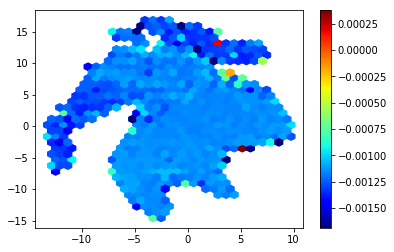

In [118]:
temp_proj = proj

x = temp_proj[:,0].ravel()
y = temp_proj[:,1].ravel()
temp_array = np.array(ukbb_asthma_joined['Asthma'].values.tolist()).ravel()
z = temp_array / np.linalg.norm(temp_array)

plt.hexbin(x,y,C=z,gridsize=30,cmap=cm.jet,bins=None)
cb=plt.colorbar()
plt.show()

In [114]:
temp_array

array([ 1., -9.,  1., ...,  1.,  1.,  1.])

In [102]:
z[0], ukbb_asthma_joined['Asthma'].values[0]

(1.0, 1.0)

In [74]:
proj_dir= '/Volumes/Stockage/alex/ukbb_projections'
out_dir = '/Volumes/Stockage/alex/ukbb_images/asthma'

for fname in os.listdir(proj_dir):
    if '3d' in fname or 'NC3' in fname or os.path.isdir(os.path.join(proj_dir,fname)) or fname=='ukbb_pca_only' \
    or os.path.exists(os.path.join(out_dir, fname + '_asthma.jpeg')):
        continue
    else:
        proj = np.loadtxt(os.path.join(proj_dir, fname))

        fig = plt.figure(figsize=(50,50))
        ax = fig.add_subplot(111, aspect=1)

        ax.scatter(proj[:,0], proj[:,1], c=asthma_colour_list, s=5, alpha=0.6)

        fig.savefig(os.path.join(out_dir, fname + '_asthma.jpeg'),format='jpeg')
        plt.close()
        print('Generated image for projection: ' + fname)

Generated image for projection: UKBB_TSNE_30PCs_DefaultPerplexity_rep_1
Generated image for projection: UKBB_TSNE_3PCs_DefaultPerplexity
Generated image for projection: UKBB_TSNE_3PCs_DefaultPerplexity_rep_1
Generated image for projection: UKBB_TSNE_40PCs_DefaultPerplexity
Generated image for projection: UKBB_TSNE_4PCs_DefaultPerplexity
Generated image for projection: UKBB_TSNE_4PCs_DefaultPerplexity_rep_1
Generated image for projection: UKBB_TSNE_5PCs_DefaultPerplexity
Generated image for projection: UKBB_TSNE_5PCs_DefaultPerplexity_rep_1
Generated image for projection: UKBB_TSNE_6PCs_DefaultPerplexity
Generated image for projection: UKBB_TSNE_6PCs_DefaultPerplexity_rep_1
Generated image for projection: UKBB_TSNE_7PCs_DefaultPerplexity
Generated image for projection: UKBB_TSNE_7PCs_DefaultPerplexity_rep_1
Generated image for projection: UKBB_TSNE_8PCs_DefaultPerplexity
Generated image for projection: UKBB_TSNE_8PCs_DefaultPerplexity_rep_1
Generated image for projection: UKBB_TSNE_9PCs

KeyboardInterrupt: 

# General plotting (plz scriptify)

In [91]:
ukbb_eth_dict_parent

defaultdict(list,
            {'Asian or Asian British': ['Indian',
              'Pakistani',
              'Bangladeshi',
              'Any other Asian background'],
             'Black or Black British': ['Caribbean',
              'African',
              'Any other Black background'],
             'Chinese': ['Chinese'],
             'Mixed': ['White and Black Caribbean',
              'White and Black African',
              'White and Asian',
              'Any other mixed background'],
             'NA': ['Do not know', 'Prefer not to answer', 'Not available'],
             'Other ethnic group': ['Other ethnic group'],
             'White': ['British', 'Irish', 'Any other white background']})

In [31]:
# Things to add:
# -Formalize list of all expected types of images to generate (eg. geo, colour scheme, subsets, etc)

proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
out_dir = '/Volumes/Stockage/alex/ukbb_images'

# Generate images for all UKBB UMAP projections
for fname in os.listdir(proj_dir):
    # Only do this for UMAP projections (TSNE added later, because ~*~I lie~*~)
    # Don't do this for 3D projections or directories
    if 'UMAP' not in fname and 'TSNE' not in fname and 'tsne' not in fname and not 'NC3' in fname \
    or os.path.isdir(os.path.join(proj_dir,fname)):
        continue
    else:
        umap_proj = np.loadtxt(os.path.join(proj_dir, fname))

        x_coords = umap_proj[:,0]
        y_coords = umap_proj[:,1]

        # North-South colouring
        if not os.path.exists(os.path.join(out_dir, fname+'_ns.jpeg')):
            fig = plt.figure(figsize=(50,50))
            ax = fig.add_subplot(111, aspect=1)

            ax.scatter(x_coords, y_coords, c=colours_ns, cmap=cm.coolwarm_r, s=5)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('bottom',size='5%',pad=0.05)

            cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
            cbar.set_label('SOUTH<---->NORTH')

            fig.savefig(os.path.join(out_dir, fname+'_ns.jpeg'),format='jpeg')
            plt.close()

        # East-West colouring
        if not os.path.exists(os.path.join(out_dir, fname+'_ew.jpeg')):
            fig = plt.figure(figsize=(50,50))
            ax = fig.add_subplot(111, aspect=1)

            ax.scatter(x_coords, y_coords, c=colours_ew, cmap=cm.spring, s=5)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('bottom',size='5%',pad=0.05)

            cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
            cbar.set_label('WEST<---->EAST')

            fig.savefig(os.path.join(out_dir, fname + '_ew.jpeg'),format='jpeg')
            plt.close()

        # Colouring by ethnicity
        if not os.path.exists(os.path.join(out_dir, fname+'_eth.jpeg')):
            fig = plt.figure(figsize=(50,50))
            ax = fig.add_subplot(111, aspect=1)

            for pop in ukbb_eth_dict_parent:
                if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
                    temp_proj = umap_proj[indices_of_population_members[pop],:]
                    ax.scatter(temp_proj[:,0], temp_proj[:,1],label=pop,color=color_dict_ukbb[pop],alpha=0.6)

                for subpop in ukbb_eth_dict_parent[pop]:
                    temp_proj = umap_proj[indices_of_population_members[subpop],:]
                    if subpop in ['Other ethnic group','Do not know']:
                        ax.scatter(temp_proj[:,0], temp_proj[:,1],marker=markers_dict[pop],label=subpop,facecolors='none',
                                edgecolors=color_dict_ukbb[subpop],alpha=0.6)
                    else:
                        ax.scatter(temp_proj[:,0], temp_proj[:,1],marker=markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop],alpha=0.6)

            ax.legend(ncol=4,loc='lower center', bbox_to_anchor=(0.4,-0.12), fontsize=40,markerscale=10)

            fig.savefig(os.path.join(out_dir, fname+'_eth.jpeg'),format='jpeg')
            plt.close()

One-off image creation (same as above, but specify a file so we don't loop through the whole list)

In [101]:
proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
out_dir = '/Volumes/Stockage/alex/ukbb_images'

fname = 'UKBB_UMAP_PC9_NC2_NN15_MD0.5_201851616510'

umap_proj = np.loadtxt(os.path.join(proj_dir, fname))

x_coords = umap_proj[:,0]
y_coords = umap_proj[:,1]

# North-South colouring
if not os.path.exists(os.path.join(out_dir, fname+'_ns.jpeg')):
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111, aspect=1)

    ax.scatter(x_coords, y_coords, c=colours_ns, cmap=cm.coolwarm_r, s=5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom',size='5%',pad=0.05)

    cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
    cbar.set_label('SOUTH<---->NORTH')

    fig.savefig(os.path.join(out_dir, fname+'_ns.jpeg'),format='jpeg')
    plt.close()

# East-West colouring
if not os.path.exists(os.path.join(out_dir, fname+'_ew.jpeg')):
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111, aspect=1)

    ax.scatter(x_coords, y_coords, c=colours_ew, cmap=cm.spring, s=5)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom',size='5%',pad=0.05)

    cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
    cbar.set_label('WEST<---->EAST')

    fig.savefig(os.path.join(out_dir, fname + '_ew.jpeg'),format='jpeg')
    plt.close()

# Colouring by ethnicity
if not os.path.exists(os.path.join(out_dir, fname+'_eth.jpeg')):
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111, aspect=1)

    for pop in ukbb_eth_dict_parent:
        if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
            temp_proj = umap_proj[indices_of_population_members[pop],:]
            ax.scatter(temp_proj[:,0], temp_proj[:,1],label=pop,color=color_dict_ukbb[pop],alpha=0.6)

        for subpop in ukbb_eth_dict_parent[pop]:
            temp_proj = umap_proj[indices_of_population_members[subpop],:]
            if subpop in ['Other ethnic group','Do not know']:
                ax.scatter(temp_proj[:,0], temp_proj[:,1],marker=markers_dict[pop],label=subpop,facecolors='none',
                        edgecolors=color_dict_ukbb[subpop],alpha=0.6)
            else:
                ax.scatter(temp_proj[:,0], temp_proj[:,1],marker=markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop],alpha=0.6)

    ax.legend(ncol=4,loc='lower center', bbox_to_anchor=(0.4,-0.12), fontsize=40,markerscale=10)

    fig.savefig(os.path.join(out_dir, fname+'_eth.jpeg'),format='jpeg')
    plt.close()

In [68]:
sklearn.__file__

'/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/__init__.py'

3d plotting

In [72]:
indices_of_population_members_ukbb = indices_of_population_members

In [99]:
items_list = []
for key in indices_of_population_members_ukbb.keys():
    items_list+=indices_of_population_members_ukbb[key]

In [102]:
len(items_list), len(set(items_list))

(488374, 488374)

In [74]:
%store ukbb_eth_dict_parent
%store indices_of_population_members_ukbb
%store color_dict_ukbb
%store markers_dict

Stored 'ukbb_eth_dict_parent' (defaultdict)
Stored 'indices_of_population_members_ukbb' (defaultdict)
Stored 'color_dict_ukbb' (dict)
Stored 'markers_dict' (dict)


In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(50,50))
ax = Axes3D(fig)

umap_proj = np.loadtxt('/Volumes/Stockage/alex/ukbb_projections/3d/UKBB_UMAP_PC10_NC3_NN10_MD0.5_2018331162028')

#x_coords = umap_proj[:,0]
#y_coords = umap_proj[:,1]
#z_coords = umap_proj[:,2]

for pop in ukbb_eth_dict_parent:
    if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
        temp_proj = umap_proj[indices_of_population_members[pop],:]
        ax.scatter(temp_proj[:,0],
                   temp_proj[:,1],
                   temp_proj[:,2],'.',label=pop,color=color_dict_ukbb[pop],alpha=0.3)

    for subpop in ukbb_eth_dict_parent[pop]:
        temp_proj = umap_proj[indices_of_population_members[subpop],:]
        ax.scatter(temp_proj[:,0], 
                   temp_proj[:,1], 
                   temp_proj[:,2], markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop],alpha=0.3)

ax.legend(ncol=4,loc='lower center', bbox_to_anchor=(0.4,-0.12), fontsize=40,markerscale=10)

fig.savefig('/Users/alex/Documents/Ethnicity/test_3d.jpeg',format='jpeg')
plt.close()

In [57]:
# Plot PCs

proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
out_dir = '/Volumes/Stockage/alex/ukbb_images'

for i in range(0,5):
    for j in range(0,5):
        if i!=j:            
            umap_proj = pca_data_array

            x_coords = umap_proj[:,i]
            y_coords = umap_proj[:,j]

            # North-South colouring
            fig = plt.figure(figsize=(50,50))
            ax = fig.add_subplot(111, aspect=1)

            ax.scatter(x_coords, y_coords, c=colours_ns, cmap=cm.coolwarm_r, s=5)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('bottom',size='5%',pad=0.05)

            cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
            cbar.set_label('SOUTH<---->NORTH')

            fig.savefig(os.path.join(out_dir, 'UKBB_PC'+str(i)+'_PC'+str(j)+'_ns.jpeg'),format='jpeg')
            plt.close()

            # East-West colouring
            fig = plt.figure(figsize=(50,50))
            ax = fig.add_subplot(111, aspect=1)

            ax.scatter(x_coords, y_coords, c=colours_ew, cmap=cm.spring, s=5)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('bottom',size='5%',pad=0.05)

            cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
            cbar.set_label('WEST<---->EAST')

            fig.savefig(os.path.join(out_dir, 'UKBB_PC'+str(i)+'_PC'+str(j)+'_ew.jpeg'),format='jpeg')
            plt.close()

            # Colouring by ethnicity

            fig = plt.figure(figsize=(50,50))
            ax = fig.add_subplot(111, aspect=1)

            for pop in ukbb_eth_dict_parent:
                if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
                    temp_proj = umap_proj[indices_of_population_members[pop],:]
                    ax.scatter(temp_proj[:,i], temp_proj[:,j],label=pop,color=color_dict_ukbb[pop],alpha=0.6)

                for subpop in ukbb_eth_dict_parent[pop]:
                    temp_proj = umap_proj[indices_of_population_members[subpop],:]
                    if subpop in ['Other ethnic group','Do not know']:
                        ax.scatter(temp_proj[:,0], temp_proj[:,1],marker=markers_dict[pop],label=subpop,facecolors='none',
                                edgecolors=color_dict_ukbb[subpop],alpha=0.6)
                    else:
                        ax.scatter(temp_proj[:,i], temp_proj[:,j],marker=markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop],alpha=0.6)

            ax.legend(ncol=4,loc='lower center', bbox_to_anchor=(0.4,-0.12), fontsize=40,markerscale=10)

            fig.savefig(os.path.join(out_dir, 'UKBB_PC'+str(i)+'_PC'+str(j)+'_eth.jpeg'),format='jpeg')
            plt.close()

# Mapping Assessment centres
http://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=54

In [49]:
ukbb_ac = pd.read_csv(os.path.join(aux_data_dir, 'ukb4940.csv'), usecols=['eid','54-0.0'])
ukbb_ac.columns=['EID_AC','AC_CODE']
ukbb_ac['EID_AC']=ukbb_ac['EID_AC'].apply(str)
ukbb_ac['AC_CODE']=ukbb_ac['AC_CODE'].apply(int)

In [53]:
ukbb_joined_ac = ukbb_df_joined2.merge(ukbb_ac, left_on='FID',right_on='EID_AC',how='left')

In [55]:
ukbb_ac_dict = {
11012:'Barts',
11021:'Birmingham',
11011:'Bristol',
11008:'Bury',
11003:'Cardiff',
11024:'Cheadle (revisit)',
11020:'Croydon',
11005:'Edinburgh',
11004:'Glasgow',
11018:'Hounslow',
11010:'Leeds',
11016:'Liverpool',
11001:'Manchester',
11017:'Middlesborough',
11009:'Newcastle',
11013:'Nottingham',
11002:'Oxford',
11007:'Reading',
11014:'Sheffield',
10003:'Stockport (pilot)',
11006:'Stoke',
11022:'Swansea',
11023:'Wrexham',
11025:'Cheadle (imaging)',
11027:'Newcastle (imaging)'}

In [ ]:
proj_path = '/Volumes/Stockage/alex/ukbb_projections/UKBB_UMAP_PC20_NC2_NN15_MD0.5_2018454111'



# Notes

* Can possibly highlight child category (relative to colour of parent category)
* Individuals identifying as mixed appear between British and non-British ancestry)
* Representation of ethnicities is uneven - much more DNK in small popupations.
* Interwoven ancestries

In [164]:
#21003-0.0 is age at assessment centre
#test = pd.read_csv('/Users/alex/Documents/Ethnicity/UKBB_pheno/ukb4940.csv')[['eid','20009-0.0']]
ukbb_pheno_age = pd.read_csv('/Users/alex/Documents/Ethnicity/UKBB_pheno/ukb4940.csv')[['eid','21003-0.0']]
ukbb_pheno_age.columns=['EID_age','age']
ukbb_pheno_age['EID_age']=ukbb_pheno_age['EID_age'].astype(str)
ukbb_pheno_age['age'] = ukbb_pheno_age['age'].fillna(0)

(array([  5489.,  46327.,  38455.,  56977.,  47022.,  70891.,  95690.,
         67917.,  71461.,   2426.]),
 array([ 37. ,  40.6,  44.2,  47.8,  51.4,  55. ,  58.6,  62.2,  65.8,
         69.4,  73. ]),
 <a list of 10 Patch objects>)

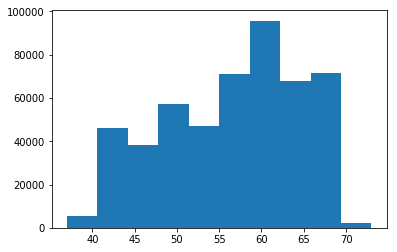

In [172]:
plt.hist(ukbb_pheno_age.age)

In [176]:
np.mean(ukbb_pheno_age.age), np.std(ukbb_pheno_age.age)

(56.528207219663585, 8.09522606665505)

# Sandbox

In [249]:
pca_data_array.shape

(488377, 40)

In [250]:
# Look at Irish and British and compare heights
len(indices_of_population_members['Irish'])

12760

In [ ]:
#    '1001':'British',
#    '1002':'Irish',
#    '1003':'Any other white background',
#    '2001':'White and Black Caribbean',
#    '2002':'White and Black African',
#    '2003':'White and Asian',
#    '2004':'Any other mixed background',
#    '3001':'Indian',
#    '3002':'Pakistani',
#    '3003':'Bangladeshi',
#    '3004':'Any other Asian background',
#    '4001':'Caribbean',
#    '4002':'African',
#    '4003':'Any other Black background',
#    '5':'Chinese',
#    '6':'Other ethnic group',
#    '-1':'Do not know',
#    '-3':'Prefer not to answer',
#    '-9':'Not available'   

In [291]:
# Filter to specific ethnicities and eliminate outliers (defined as residuals beyond 25cm after age/sex controls)
irish = ukbb_pheno_joined_height_res.loc[(ukbb_pheno_joined_height_res['eth1_str']=='1002')]
irish = irish.loc[np.abs(irish['Height_res']) < 25]
british = ukbb_pheno_joined_height_res.loc[(ukbb_pheno_joined_height_res['eth1_str']=='1001')]
british = british.loc[np.abs(british['Height_res']) < 25]
chinese = ukbb_pheno_joined_height_res.loc[(ukbb_pheno_joined_height_res['eth1_str']=='5')]
chinese = chinese.loc[np.abs(chinese['Height_res']) < 25]

In [307]:
irish_female = irish.loc[irish['sex']=='0']
british_female = british.loc[british['sex']=='0']
chinese_female = chinese.loc[chinese['sex']=='0']
irish_male = irish.loc[irish['sex']=='1']
british_male = british.loc[british['sex']=='1']
chinese_male = chinese.loc[chinese['sex']=='1']

In [308]:
irish_female.Height_res.mean(), british_female.Height_res.mean(), chinese_female.Height_res.mean()

(-0.5582999729827334, 0.20452924251129317, -5.506948277784593)

In [254]:
irish_female.Height_res.std(), british_female.Height_res.std()

(5.988839621285557, 6.0870846208491)

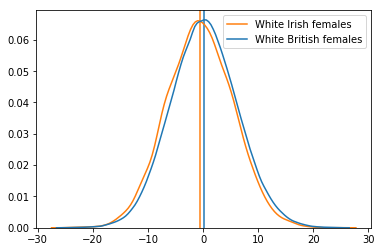

In [255]:
sns.kdeplot(np.array(irish_female.Height_res.values.tolist()),label='White Irish females',color=sns.color_palette()[1])
sns.kdeplot(np.array(british_female.Height_res.values.tolist()),label='White British females',color=sns.color_palette()[0])
plt.vlines(x=np.mean(irish_female.Height_res.values),ymin=0,ymax=0.07,color=sns.color_palette()[1])
plt.vlines(x=np.mean(british_female.Height_res.values),ymin=0,ymax=0.07,color=sns.color_palette()[0])

#sns.kdeplot(np.array(temp_list),bw=0.5, label=k)

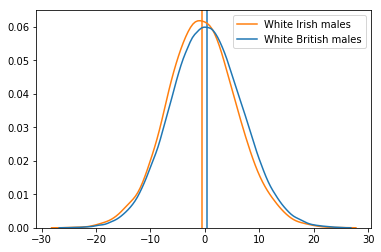

In [256]:
sns.kdeplot(np.array(irish_male.Height_res.values.tolist()),label='White Irish males',color=sns.color_palette()[1])
sns.kdeplot(np.array(british_male.Height_res.values.tolist()),label='White British males',color=sns.color_palette()[0])
plt.vlines(x=np.mean(irish_male.Height_res.values),ymin=0,ymax=0.07,color=sns.color_palette()[1])
plt.vlines(x=np.mean(british_male.Height_res.values),ymin=0,ymax=0.07,color=sns.color_palette()[0])

In [257]:
np.mean(irish_male.Height_res.values), np.mean(british_male.Height_res.values)

(-0.5614857567470336, 0.28494659796132804)

In [261]:
from scipy.stats import ttest_ind

print(ttest_ind(irish_female['Height_res'], british_female['Height_res']))
print(ttest_ind(irish_male['Height_res'], british_male['Height_res']))

Ttest_indResult(statistic=-10.052216275629585, pvalue=9.0806016793400283e-24)
Ttest_indResult(statistic=-9.8439459377713074, pvalue=7.3660671147555365e-23)


In [262]:
x = ttest_ind(irish_female['Height_res'], british_female['Height_res'])

In [263]:
british_female['Height_res'].agg('mean') - irish_female['Height_res'].agg('mean')

0.7628292154940266

In [264]:
british_male['Height_res'].agg('mean') - irish_male['Height_res'].agg('mean')

0.846432354708273

In [265]:
british_male['Height_res'].values

array([ -0.79676774,   9.44386291,  -9.14259354, ...,  11.23588495,
        -1.1776586 ,   2.78727635])

In [289]:
?plt.title

In [499]:
ukbb_pheno_joined_height_res_label = pd.merge(ukbb_pheno_joined_height_res, ukbb_eth_df, left_on='eth1_str', \
                                              right_on='eth_code', how='left')
plot_height_df_f = ukbb_pheno_joined_height_res_label.loc[ukbb_pheno_joined_height_res_label['sex']=='0']
plot_height_df_m = ukbb_pheno_joined_height_res_label.loc[ukbb_pheno_joined_height_res_label['sex']=='1']

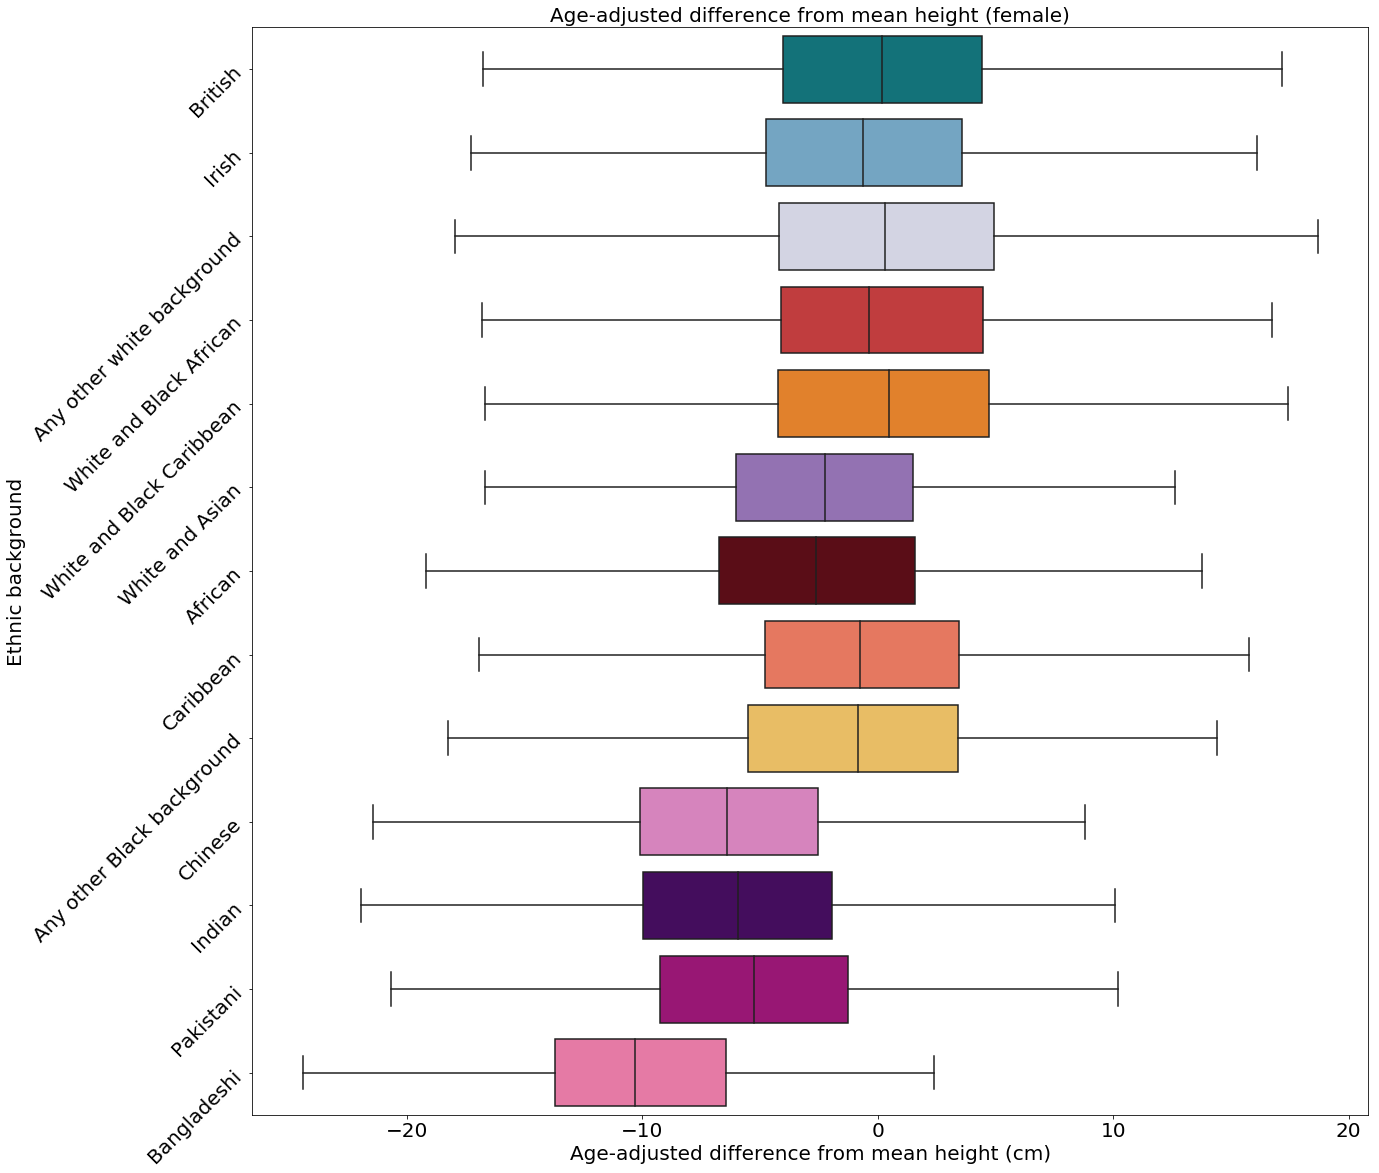

In [500]:
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(ax = ax, orient='h',
            palette = color_dict_ukbb,
            y = 'eth_txt',
            x = 'Height_res',
            showfliers=False,
            order = ['British','Irish','Any other white background',
                     'White and Black African','White and Black Caribbean',
                     'White and Asian',
                     'African','Caribbean','Any other Black background',
                     'Chinese',
                     'Indian','Pakistani','Bangladeshi'],
           data = ukbb_pheno_joined_height_res_label)

ax.set_xlabel('Age-adjusted difference from mean height (cm)')
ax.set_ylabel('Ethnic background')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_title('Age-adjusted difference from mean height (female)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

Older boxplot code below

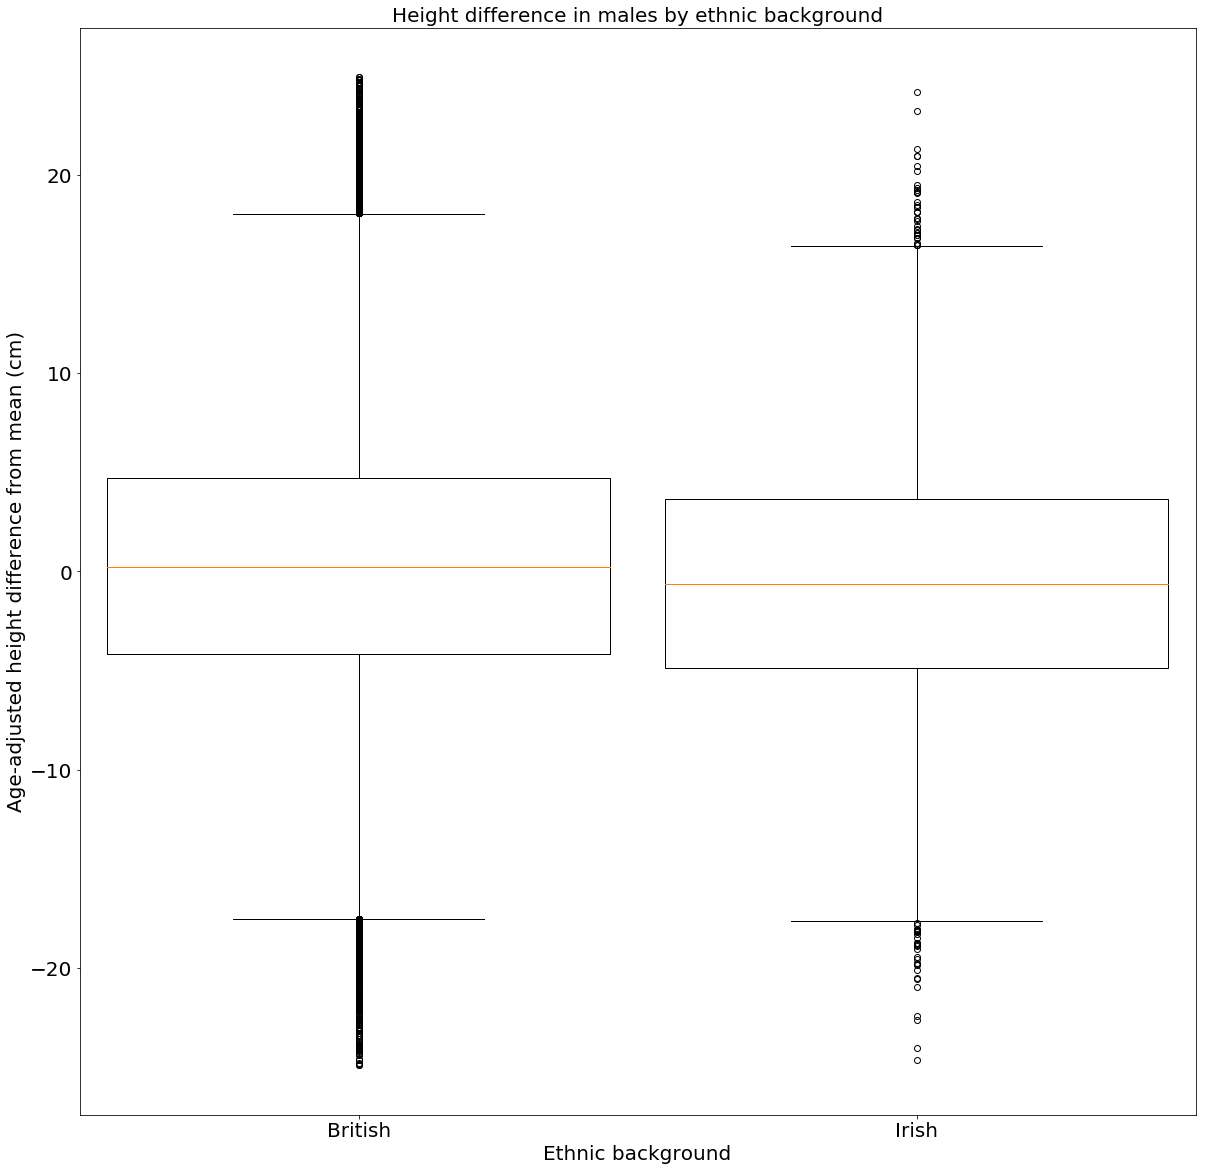

In [306]:
plt.figure(figsize=(20,20))
labels = ['British','Irish']
ax = plt.subplot(111, xlabel='Ethnic background', ylabel='Age-adjusted height difference from mean (cm)')
plt.boxplot((british_male['Height_res'].values, irish_male['Height_res'].values), labels=labels, widths=0.9)
plt.title('Height difference in males by ethnic background')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
plt.savefig('/Volumes/Stockage/alex/ukbb_images/other/male_height_irish_british_boxplot.jpeg')

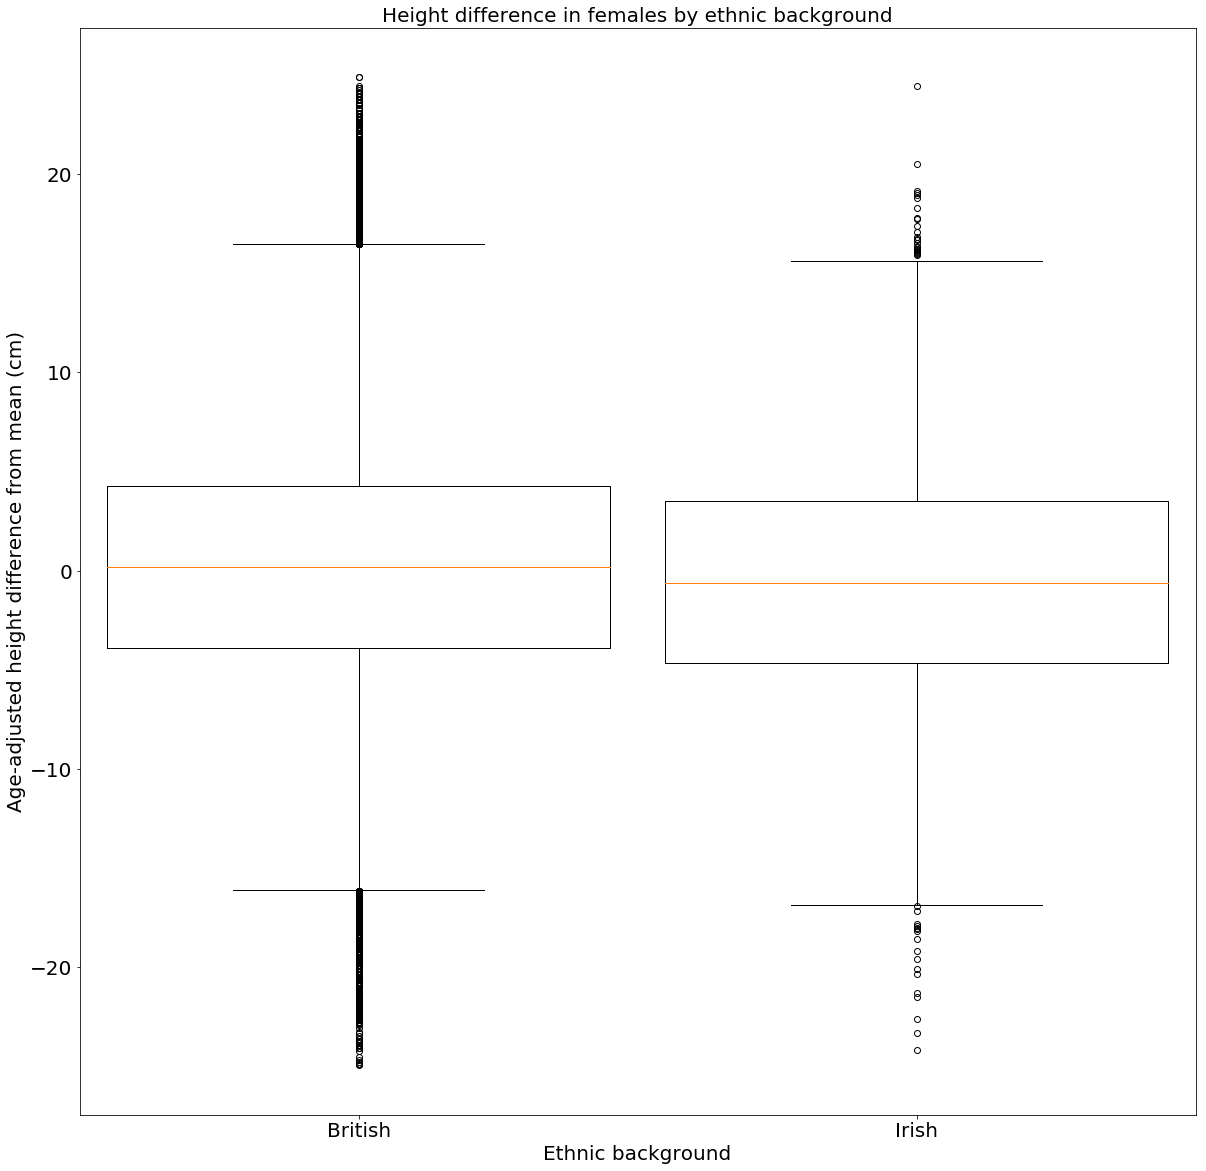

In [305]:
plt.figure(figsize=(20,20))
labels = ['British','Irish']
ax = plt.subplot(111, xlabel='Ethnic background', ylabel='Age-adjusted height difference from mean (cm)')
plt.boxplot((british_female['Height_res'].values, irish_female['Height_res'].values), labels=labels, widths=0.9)
plt.title('Height difference in females by ethnic background')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.savefig('/Volumes/Stockage/alex/ukbb_images/other/female_height_irish_british_boxplot.jpeg')